In [278]:
import os
import pathlib
from pathlib import Path
import re

import pandas as pd
import numpy as np

In [2]:
workdir='CNN_multitask_grid'
os.chdir('/users/qdb16186')
path=os.getcwd()
abs_dir=path+"/"+workdir

# Bash_script

In [11]:
def bash_script_gen(abs_dir):
    dir=abs_dir
    cores=15
    HH=48
    job_name="CNN_single_task_Granulated_15_cores"
    python_script="CNN_single_task_Granulated.py"
    with open(f'{dir}/sbatch_.sh','w') as f:
        f.write(f"""#!/bin/bash

#======================================================
#
# Job script for running on a single node
#
#======================================================

#======================================================
# Propogate environment variables to the compute node
#SBATCH --export=ALL
#
# Run in the standard partition (queue)
#SBATCH --partition=standard
#
# Specify project account
#SBATCH --account=palmer-addmd
#
# No. of tasks required
#SBATCH --ntasks=1 --cpus-per-task={cores}
#
# Distribute processes in round-robin fashion for load balancing
#SBATCH --distribution=cyclic
#
#
# Specify (hard) runtime (HH:MM:SS)
#SBATCH --time={HH}:00:00
#
# Job name
#SBATCH --job-name={job_name}
#
# Output file
#SBATCH --output={job_name}_slurm-%j.out
#======================================================

module purge
module load anaconda/python-3.9.7/2021.11
source activate tf
module purge

#======================================================
# Prologue script to record job details
# Do not change the line below
#======================================================
/opt/software/scripts/job_prologue.sh
#------------------------------------------------------

python {python_script}
#mpirun -np $SLURM_NTASKS namd2 HEWL_002M_D2.inp > HEWL_002M_D2.out.$SLURM_JOB_ID 

#======================================================
# Epilogue script to record job endtime and runtime
# Do not change the line below
#======================================================
/opt/software/scripts/job_epilogue.sh
#------------------------------------------------------
""")
        f.close
        


In [12]:
bash_script_gen(abs_dir)

# Python Script

In [70]:
def python_script(abs_dir):
    dir=abs_dir
    cores=15
    HH=48
    job_name="CNN_single_task_Granulated_15_cores"
    python_script="CNN_single_task_Granulated.py"
    with open(f'{dir}/python_script.py','w') as f:
        f.write("""import numpy as np
import pandas as pd

import glob
import random

# sklearn inports
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import make_scorer


import os
import pathlib
# import pickle as pk

### Tensorflow
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers, models, initializers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# Check if these are in model
# from tensorflow.keras.losses import Reduction 
# from tensorflow.keras.losses import MeanAbsoluteError
# Finish check

from scikeras.wrappers import KerasRegressor

#Functions
## Loading Data from CSV file
def padding(X_descr_train_scaled):
#     Padding function so X data is always 250 dimensions
# Must be coupled with load_data. NB! double check if the scalling is not affected
# https://www.geeksforgeeks.org/python-call-function-from-another-function/
    a=X_descr_train_scaled.to_numpy()
    b=np.zeros((len(X_descr_train_scaled), 
                (250-int(X_descr_train_scaled.to_numpy().shape[1]))
               )
              )
    padded=np.concatenate((a,b),
                           axis=1, 
                          out=None, 
                          dtype=None
                         )
    return padded

def df_np(y):
#     y is a list
    y_out=[]
    for y_i in y:
        y_ic=y_i.to_numpy()
        y_ic=y_ic.reshape(y_ic.shape[0])
        y_out.append(y_ic)
    return y_out

def load_data(file,prop):
# Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()
    
    # Convert y data into required input shape
    y_1 = y_1.to_numpy()
    y_1 = y_1.reshape(y_1.shape[0])
    y_2 = y_2.to_numpy()
    y_2 = y_2.reshape(y_2.shape[0])
    y_3 = y_3.to_numpy()
    y_3 = y_3.reshape(y_3.shape[0])
    y_4 = y_4.to_numpy()
    y_4 = y_4.reshape(y_4.shape[0])
    
    # Load features based on prop
    X = file[[col for col in file.columns if f'{prop}_'in col]]
    
    return y_1, y_2, y_3, y_4, padding(X), X


def load_data_df(file,prop):
# Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()
    
    # Load features based on prop
    X = file[[col for col in file.columns if f'{prop}_'in col]]
    
    return y_1, y_2, y_3, y_4, X

def wrapped_train_test_split(train_idx,test_idx,file,prop):
#     capittal Y and X stand for pandas dataframe like file
    Y_1, Y_2, Y_3, Y_4, X = load_data_df(file,prop)

    # Separate data into training and test sets:
    x_train = X.iloc[train_idx]
    x_test = X.iloc[test_idx]
#     The next two lines (y) will vary depending on the CNN output
    y_train = [Y_1.iloc[train_idx],Y_2.iloc[train_idx],Y_3.iloc[train_idx],Y_4.iloc[train_idx]]
    y_test  = [Y_1.iloc[test_idx] ,Y_2.iloc[test_idx] ,Y_3.iloc[test_idx] ,Y_4.iloc[test_idx]]
    
    return padding(x_train), padding(x_test), df_np(y_train), df_np(y_test)


def create_dir(home,resample,model_name,prop,GSHT):
    if home==None:
        home=os.getcwd()
    try:
            os.mkdir("{}/CV/".format(home))
    except:
            pass
    os.chdir("{}/CV/".format(home))
    try:
        os.mkdir("{}".format(resample))
    except:
            pass
    os.chdir("{}".format(resample))
    try:
        os.mkdir("{}".format(model_name))
    except:
            pass
    os.chdir("{}".format(model_name))
    try:
        os.mkdir("{}".format(prop))
    except:
            pass
    os.chdir("{}".format(prop))
    try:
        os.mkdir("{}".format(GSHT))
    except:
            pass
    os.chdir("{}".format(GSHT))
    try:
        os.mkdir('{}'.format('csv_logger'))
    except:
        pass
    try:
        os.mkdir('{}'.format('model_checkpoint'))
    except:
        pass
    try:
        os.mkdir('{}'.format('tensorboard_logs'))
    except:
        pass
    os.chdir("{}".format('model_checkpoint'))
    try:
        os.mkdir('training_{}'.format(resample))
    except:
        pass
    os.chdir("{}".format(home))
    return

def r2_func(y_true, y_pred, **kwargs):
    return metrics.r2_score(y_true, y_pred)
def rmse_func(y_true, y_pred, **kwargs):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))  
def bias_func(y_true, y_pred, **kwargs):
    return np.mean(y_true-y_pred)
def sdep_func(y_true, y_pred, **kwargs):
    return (np.mean((y_true-y_pred-(np.mean(y_true-y_pred)))**2))**0.5
#these 4 are for tensorflow formats
def r2_func_tf(y_true, y_pred, **kwargs):
    numerator = tf.reduce_sum(tf.square(y_true - y_pred))
    denominator = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - numerator / denominator
    return r2
def rmse_func_tf(y_true, y_pred, **kwargs):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    rmse = tf.sqrt(mse)
    return rmse
def bias_func_tf(y_true, y_pred, **kwargs):
    bias = tf.reduce_mean(y_true - y_pred)
    return bias
def sdep_func_tf(y_true, y_pred, **kwargs):
    diff = y_true - y_pred
    mean_diff = tf.reduce_mean(diff)
    sdep = tf.sqrt(tf.reduce_mean(tf.square(diff - mean_diff)))
    return sdep

def save_splits(idx,true,pred,resample,path,split_type):
    y_outputs = pd.DataFrame()
    y_outputs['ID'] = idx
    y_outputs['y_true'] = true
    y_outputs['y_pred'] = pred
    y_outputs.to_csv(f'{path}/Split_{resample}_type_{split_type}.csv', index=False)
    return

def build_model(dense1,dense2,dense3,convn,**kwargs):
    
    print("dense1: ", dense1)
    
    print("dense2: ", dense2)
    
    print("dense3: ", dense3)

    print("convn: ", convn)
    
#     INPUT for NN
    
    inputs = keras.Input(shape=(250,1))
    x=inputs
    
#     MANDATORY CNN (optional to move into first condition hp.cond_scope
    if convn > 0:
        x = keras.layers.Conv1D(32, 
                            kernel_size=(3), 
                            strides=(2), 
                            padding='valid', 
                            activation='relu', 
                            input_shape=(250,1),
                            name = 'conv1d_1'
                            )(x)
        x = keras.layers.MaxPooling1D((2), name = 'maxpooling_1')(x)
        x = keras.layers.BatchNormalization(name = 'batchnorm_1')(x)
    
#     CONDITIONAL CONVOLUTION LAYERS (Consider moving the above into CNN1) test 0-3 CNN and 0-3 Dense
    if convn > 1:
        x = keras.layers.Conv1D(32, 
                            kernel_size=(3), 
                            strides=(2), 
                            padding='valid', 
                            activation='relu', 
                            name = f'conv1d_2'
                            )(x)
        x = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x)
        x = keras.layers.BatchNormalization(name = f'batchnorm_2')(x)   
    if convn > 2:
        x = keras.layers.Conv1D(32, 
                            kernel_size=(3), 
                            strides=(2), 
                            padding='valid', 
                            activation='relu', 
                            name = f'conv1d_3'
                            )(x)
        x = keras.layers.MaxPooling1D((2), name = f'maxpooling_3')(x)
        x = keras.layers.BatchNormalization(name = f'batchnorm_3')(x)            
#     FLATTEN AFTER CONVOLUTIONS
    if convn > -1:
        x = keras.layers.Flatten(name = 'flatten')(x)
    
#     CONDITIONAL DENSE LAYERS
    if dense1 >0:
        x = keras.layers.Dense(
                    dense1,
                    activation='relu',
                    use_bias=True,
                    # name='layer_1',
                    kernel_initializer='glorot_uniform',
                    bias_initializer='zeros',
                    kernel_regularizer=None,
                    bias_regularizer=None,
                    activity_regularizer=None,
                    kernel_constraint=None,
                    bias_constraint=None
                )(x)
    if dense2 >0:
        x = keras.layers.Dense(
                        dense2,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x)
    if dense3 >0:
        x = keras.layers.Dense(
                        dense3,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x)
#     OUTPUT LAYERS
    output_1 = keras.layers.Dense(1, name='enthalpy_pred')(x)
    # output_2 = keras.layers.Dense(1, name='entropy_pred')(x)
    # output_3 = keras.layers.Dense(1, name='free_energy_pred')(x)

    # model = Model(inputs=inputs, outputs=[output_1, output_2, output_3])
    model = Model(inputs=inputs, outputs=output_1)
    
#     SETTINGS ADAPTIVE LEARNING RATE   
    initial_learning_rate = 0.01
    decay_steps = 10.0
    decay_rate = 0.5
    learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
                                    initial_learning_rate, decay_steps, decay_rate)
    
#     SETTING ADAM OPTIMISER
    optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
    
#     COMPILE MODEl
    model.compile(loss = "mse" , 
                  optimizer = optimiser, 
                  metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
    
    return model

### MODEL END Start Workflow

### Keras Model REgressor Ready for Grid Search
def model_for_grid(resultdir,resample,epochs,**kwargs):
#Needs variable epochs 
    es = EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       verbose=1, 
                       patience=2000, 
                       restore_best_weights=True)
    # CSV Logger
    csv_logger = CSVLogger(f"{resultdir}/csv_logger/model_history_log_resample_{resample}.csv", 
                           append=True)
    # # CP_callbacks
    # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{resultdir}/model_checkpoint/training_{resample}/cp.ckpt',
    #                                                  save_weights_only=True,
    #                                                  verbose=1)
    
    # TensorBoard
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f'{resultdir}/tensorboard_logs/{resample}', #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                          update_freq = 1,
                                                          # histogram_freq=1, 
                                                          write_graph=False, 
                                                          write_images=False)
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
    
    # Covert to list and provide to Keras Regressor
    keras_callbacks = [es, csv_logger, tensorboard_callback]
        
    ###initialise model
    model = KerasRegressor(model=build_model, 
                           batch=32,
                            epochs=epochs,
                            verbose=1,
                            validation_split=0.2,
                           callbacks=keras_callbacks,
                           dense1=1,
                            dense2=1,
                            dense3=1,
                           convn=1
                          )

    return model


### Input Parameters and Workflow

# Initialise
file=pd.read_csv("Lomzov_dataset_IY.csv")
# parameters to work with
prop='Granulated'
# obtain y and x data
y_1, y_2, y_3, y_4, x, X= load_data(file,prop)

# desc_type = ['RF-Score','H-Bonding','Granulated','DNA-Groups','OHEP','LP_dec2','CountDNA','CountDNAp']
desc_type = ['Granulated','OHEP','LP_dec2']

GSHT_list=['dH','dS','dG','Tm'] #get the order correct
#### WORK
#### MAC sklearn for CNN

###set global variables
# train test split
test_frac = 0.3
home=os.getcwd()
mc_cv=50
n_folds=5
n_jobs=1
epochs=200
grid_number=1
# Initialise train test split:
train_test_split = ShuffleSplit(mc_cv, test_size=test_frac, random_state=1)
train_test_split_hp = ShuffleSplit(n_folds, test_size=0.3, random_state=1)

###define scoring dict for cv
scorers = {
    'r2':make_scorer(r2_func), 
    'rmse':make_scorer(rmse_func, greater_is_better=False), 
    'bias':make_scorer(bias_func, greater_is_better=False), 
    'sdep':make_scorer(sdep_func, greater_is_better=False)
    }

# Monte Carlo CV:
resample=0
for train_idx, test_idx in train_test_split.split(x):
    resample+=1   

    
    for prop in desc_type:
    #     adjust y[2] to * Temperature /1000 dS*T kcal/mol
        #for CNN with padding
        x_train, x_test, y_train, y_test = wrapped_train_test_split(train_idx,test_idx,file,prop)


        i=-1
        for GSHT in GSHT_list:
            i+=1

            ### DEFINE MODEL
            model_name = f'CNN_single_task_grid_{grid_number}'
            
            path="{}/CV/{}/{}/{}/{}".format(os.getcwd(),resample,model_name,prop,GSHT)
            
            model = model_for_grid(path,resample,epochs) #resultdir
            
            create_dir(home,resample,model_name,prop,GSHT)
            
            ### Grid            
            pipe_cond='No_scalling'
            for pipe_cond in ['No_scalling']:#,'Scalling']: 
                # Until we find a way to normalise the data in this pipeline. 
                # We can do it with hyper_tunner 
                # NB! Do not forget to adjust the keras callbacks becasue they will overwrite No_scalling outputs
                if pipe_cond=="Scalling":        
                    ### PIPE
                    # Define inputs for pipe
                    scaler = StandardScaler()
                    pipe = Pipeline(steps=[("scaler", scaler), (f"{model_name}",model)])
            
                     ###parameter grid
                    param_grid_model = {
                                     f"{model_name}__dense1":[8,16,32],
                                     f"{model_name}__dense2":[8,16,32],
                                     f"{model_name}_dense3":[8,16,32],
                                        f"{model_name}__convn":[0]}
                    
                    ###create CV using sklearn.GridSearchCV
                    grid = GridSearchCV(
                        estimator=pipe, 
                        param_grid=param_grid_model,
                        n_jobs=n_jobs, 
                        cv=n_folds, 
                        refit='rmse', 
                        scoring=scorers, 
                        return_train_score=True,
                        )
        
                else:
                    ###parameter grid
                    param_grid_model = {                     
                                 "dense1":[32],
                                 "dense2":[32],
                                 "dense3":[8,32],
                                 'convn':[3]}
                    
                    ###create CV using sklearn.GridSearchCV
                    grid = GridSearchCV(
                        estimator=model,
                        param_grid=param_grid_model,
                        n_jobs=n_jobs, 
                        cv=n_folds, 
                        refit='rmse', 
                        scoring=scorers, 
                        return_train_score=True,
                        )
    
        ########### Fid Model with Scikeras and scikit learn.
                history = grid.fit(x_train, y_train[i])
       ############ Store results
    
                results=pd.DataFrame(history.cv_results_)
                results.to_csv(path+f"/gridsearch_resample_{resample}_pipe_cond_{pipe_cond}.csv")
    
                y_pred_test=history.predict(x_test)
                y_pred_train=history.predict(x_train)
    
                save_splits(train_idx,y_train[i],y_pred_train,resample,path,f"train_pipe_cond_{pipe_cond}")
                save_splits(test_idx,y_test[i],y_pred_test,resample,path,f"test_pipe_cond_{pipe_cond}")
        
# total_time=time.time()-time_start


""")
        f.close
        


# Python Multitask 4


In [3]:
def python_script(abs_dir,prop,GSHT,cores,job_resample,job_i_fold):
    dir=abs_dir
    cores=1
    job_name=f"{job_resample}_{job_i_fold}_{prop}_CNN_multi_task_{GSHT}_{cores}"
    python_script=f"{job_resample}_{job_i_fold}_{prop}_CNN_multi_task_{GSHT}_{cores}.py"
    with open(f'{dir}/{python_script}','w') as f:
        f.write("""import numpy as np
import pandas as pd

# import sklearn
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import make_scorer


import os
import pathlib


### Tensorflow
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers, models, initializers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# Check if these are in model
# from tensorflow.keras.losses import Reduction 
# from tensorflow import tensorflow.keras.losses.Reduction
# from tensorflow.keras.losses import Loss
# from tensorflow.keras.losses import MeanAbsoluteError
# Finish check


from scikeras.wrappers import KerasRegressor

#Functions
## Loading Data from CSV file
def padding(X_descr_train_scaled):
#     Padding function so X data is always 250 dimensions
# Must be coupled with load_data. NB! double check if the scalling is not affected
# https://www.geeksforgeeks.org/python-call-function-from-another-function/
    a=X_descr_train_scaled.to_numpy()
    b=np.zeros((len(X_descr_train_scaled), 
                (250-int(X_descr_train_scaled.to_numpy().shape[1]))
               )
              )
    padded=np.concatenate((a,b),
                           axis=1, 
                          out=None, 
                          dtype=None
                         )
    return padded

def df_np(y):
#     y is a list
    y_out=[]
    for y_i in y:
        y_ic=y_i.to_numpy()
        y_ic=y_ic.reshape(y_ic.shape[0])
        y_out.append(y_ic)
    return y_out

def load_data(file,prop):
# Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()
    
    # Convert y data into required input shape
    y_1 = y_1.to_numpy()
    y_1 = y_1.reshape(y_1.shape[0])
    y_2 = y_2.to_numpy()
    y_2 = y_2.reshape(y_2.shape[0])
    y_3 = y_3.to_numpy()
    y_3 = y_3.reshape(y_3.shape[0])
    y_4 = y_4.to_numpy()
    y_4 = y_4.reshape(y_4.shape[0])
    
    # Load features based on prop
    X = file[[col for col in file.columns if f'{prop}_'in col]]
    
    return y_1, y_2, y_3, y_4, padding(X), X


def load_data_df(file,prop):
# Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()
    
    # Load features based on prop
    x_layer = file[[col for col in file.columns if f'{prop}_'in col]]
    
    return y_1, y_2, y_3, y_4, X

def wrapped_train_test_split(train_idx,test_idx,file,prop):
#     capittal Y and X stand for pandas dataframe like file
    Y_1, Y_2, Y_3, Y_4, x_layer = load_data_df(file,prop)

    # Separate data into training and test sets:
    x_train = X.iloc[train_idx]
    x_test = X.iloc[test_idx]
#     The next two lines (y) will vary depending on the CNN output
    y_train = [Y_1.iloc[train_idx],Y_2.iloc[train_idx],Y_3.iloc[train_idx],Y_4.iloc[train_idx]]
    y_test  = [Y_1.iloc[test_idx] ,Y_2.iloc[test_idx] ,Y_3.iloc[test_idx] ,Y_4.iloc[test_idx]]
    
    return padding(x_train), padding(x_test), df_np(y_train), df_np(y_test)

def wrapped_train_test_split_no_padding(train_idx,test_idx,file,prop):
#     capittal Y and X stand for pandas dataframe like file
    Y_1, Y_2, Y_3, Y_4, x_layer = load_data_df(file,prop)

    # Separate data into training and test sets:
    x_train = X.iloc[train_idx]
    x_test = X.iloc[test_idx]
#     The next two lines (y) will vary depending on the CNN output
    y_train = [Y_1.iloc[train_idx],Y_2.iloc[train_idx],Y_3.iloc[train_idx],Y_4.iloc[train_idx]]
    y_test  = [Y_1.iloc[test_idx] ,Y_2.iloc[test_idx] ,Y_3.iloc[test_idx] ,Y_4.iloc[test_idx]]
    
    return x_train, x_test, df_np(y_train), df_np(y_test)

def create_dir(home,resample,model_name,prop,GSHT,i_fold):
    if home==None:
        home=os.getcwd()
    try:
            os.mkdir("{}/CV/".format(home))
    except:
            pass
    os.chdir("{}/CV/".format(home))
    try:
        os.mkdir("{}".format(resample))
    except:
            pass
    os.chdir("{}".format(resample))
    try:
        os.mkdir("{}".format(model_name))
    except:
            pass
    os.chdir("{}".format(model_name))
    try:
        os.mkdir("{}".format(prop))
    except:
            pass
    os.chdir("{}".format(prop))
    try:
        os.mkdir("{}".format(GSHT))
    except:
            pass
    os.chdir("{}".format(GSHT))

    try:
        os.mkdir("fold_{}".format(i_fold))
    except:
            pass
    os.chdir("fold_{}".format(i_fold))
    
    try:
        os.mkdir('{}'.format('csv_logger'))
    except:
        pass
    try:
        os.mkdir('{}'.format('model_checkpoint'))
    except:
        pass
    try:
        os.mkdir('{}'.format('tensorboard_logs'))
    except:
        pass
    os.chdir("{}".format('model_checkpoint'))
    try:
        os.mkdir('training_{}'.format(resample))
    except:
        pass
    os.chdir("{}".format(home))
    return

def r2_func(y_true, y_pred, **kwargs):
    return metrics.r2_score(y_true, y_pred)
def rmse_func(y_true, y_pred, **kwargs):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))  
def bias_func(y_true, y_pred, **kwargs):
    return np.mean(y_true-y_pred)
def sdep_func(y_true, y_pred, **kwargs):
    return (np.mean((y_true-y_pred-(np.mean(y_true-y_pred)))**2))**0.5
#these 4 are for tensorflow formats
def r2_func_tf(y_true, y_pred, **kwargs):
    numerator = tf.reduce_sum(tf.square(y_true - y_pred))
    denominator = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - numerator / denominator
    return r2
def rmse_func_tf(y_true, y_pred, **kwargs):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    rmse = tf.sqrt(mse)
    return rmse
def bias_func_tf(y_true, y_pred, **kwargs):
    bias = tf.reduce_mean(y_true - y_pred)
    return bias
def sdep_func_tf(y_true, y_pred, **kwargs):
    diff = y_true - y_pred
    mean_diff = tf.reduce_mean(diff)
    sdep = tf.sqrt(tf.reduce_mean(tf.square(diff - mean_diff)))
    return sdep

def save_splits(idx,true,pred,resample,path,split_type):
    y_outputs = pd.DataFrame()
    y_outputs['ID'] = idx
    if len(true)==4:
        for i in len(true):
            y_outputs[f'y_true_{i}'] = true
            y_outputs[f'y_pred_{i}'] = pred
    y_outputs.to_csv(f'{path}/Split_{resample}_type_{split_type}.csv', index=False)
    return

def save_splits_hp(idx,true_y,true_x,resample,path,split_type):
    y_outputs = pd.DataFrame()
    y_outputs['ID'] = idx
    if len(true_y)==4:
        for i in range(len(true_y)):
            y_outputs[f'y_true_{i}'] = true_y[i]
    y_outputs.to_csv(f'{path}/Split_y_{resample}_type_{split_type}.csv', index=False)

    x_inputs=pd.DataFrame(true_x)
    x_inputs.to_csv(f'{path}/Split_x_{resample}_type_{split_type}.csv', index=False)
    return

def build_model(hp):
    
#     Hyper parameters         
    model_type1 = hp.Choice("model_type1", ["CNN3","CNN2","CNN1"])
    model_type = hp.Choice("model_type", ["Dense3"])
 
    
#     INPUT for NN
    
    inputs = keras.Input(shape=(250,1))
    x_layer=inputs
    
#     MANDATORY CNN (optional to move into first condition hp.cond_scope
    # with hp.conditional_scope("model_type1", ["CNN0"]):
    #         if model_type1 == "CNN0":
    #             pass
#     CONDITIONAL CONVOLUTION LAYERS (Consider moving the above into CNN1) test 0-3 CNN and 0-3 Dense
    with hp.conditional_scope("model_type1", ["CNN1","CNN2""CNN3"]):
            if model_type1 != "CNN0":
                x_layer = keras.layers.Conv1D(32, 
                        kernel_size=(3), 
                        strides=(2), 
                        padding='valid', 
                        activation='relu', 
                        input_shape=(250,1),
                        name = 'conv1d_1'
                        )(x_layer)
                x_layer = keras.layers.MaxPooling1D((2), name = 'maxpooling_1')(x_layer)
                x_layer = keras.layers.BatchNormalization(name = 'batchnorm_1')(x_layer)
                pass
                
            if model_type1 != "CNN1":
                x_layer = keras.layers.Conv1D(32, 
                                    kernel_size=(3), 
                                    strides=(2), 
                                    padding='valid', 
                                    activation='relu', 
                                    name = f'conv1d_2'
                                    )(x_layer)
                x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x_layer)
                x_layer = keras.layers.BatchNormalization(name = f'batchnorm_2')(x_layer)

            if model_type1 != "CNN1" or "CNN2":               
                x_layer = keras.layers.Conv1D(32, 
                                    kernel_size=(3), 
                                    strides=(2), 
                                    padding='valid', 
                                    activation='relu', 
                                    name = f'conv1d_3'
                                    )(x_layer)
                x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_3')(x_layer)
                x_layer = keras.layers.BatchNormalization(name = f'batchnorm_3')(x_layer)
                
#     FLATTEN AFTER CONVOLUTIONS
    x_layer = keras.layers.Flatten(name = 'flatten')(x_layer)
    
#     CONDITIONAL DENSE LAYERS
    # with hp.conditional_scope("model_type", ["Dense0"]):
    #     if model_type == "Dense0":
    #         pass
            
    with hp.conditional_scope("model_type", ["Dense3"]): #["Dense1","Dense2","Dense3"]
        if model_type != "Dense0":
            hp_layer_1= hp.Choice(f'layer_1', values=[16,32,64,128])

            x_layer = keras.layers.Dense(
                        hp_layer_1,
                        activation='relu',
                        use_bias=True,
                        # name='layer_1',
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x_layer)
        if model_type != "Dense1":
            hp_layer_2_2= hp.Choice(f'layer_2_2', values=[16,32,64,128])

            x_layer = keras.layers.Dense(
                        hp_layer_2_2,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x_layer)

        if model_type != "Dense1" or "Dense2":
            hp_layer_3_3= hp.Choice(f'layer_3_3',  values=[16,32,64])
            
            x_layer = keras.layers.Dense(
                        hp_layer_3_3,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x_layer)
#     OUTPUT LAYERS

    # output_1 = keras.layers.Dense(1, name='enthalpy_pred')(x_layer)
    # output_2 = keras.layers.Dense(1, name='entropy_pred')(x_layer)
    # output_3 = keras.layers.Dense(1, name='free_energy_pred')(x_layer)
    # output_4 = keras.layers.Dense(1, name='melting_temperature')(x_layer)

    output_1 = keras.layers.Dense(1, name='dH')(x_layer)
    output_2 = keras.layers.Dense(1, name='dS')(x_layer)
    output_3 = keras.layers.Dense(1, name='dG')(x_layer)
    output_4 = keras.layers.Dense(1, name='Tm')(x_layer)
    

    model = Model(inputs=inputs, outputs=[output_1, output_2, output_3, output_4])
    # model = Model(inputs=inputs, outputs=output_1)
    
#     SETTINGS
#     SETTINGS

#     ADAPTIVE LEARNING RATE   
    
    initial_learning_rate = 0.01
    decay_steps = 10.0
    decay_rate = 0.5
    learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
                                    initial_learning_rate, decay_steps, decay_rate)
    
#     SETTING ADAM OPTIMISER
    optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
    
#     COMPILE MODEl
    model.compile(loss = "mse" , 
                  optimizer = optimiser, 
                  metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
    
    return model

### MODEL END Start Workflow


### 2 more FUNCTIONS


# def model_for_grid(resultdir,resample,epochs,**kwargs):
# #Needs variable epochs 
#     es = EarlyStopping(monitor='val_loss', 
#                        mode='min', 
#                        verbose=1, 
#                        patience=2000, 
#                        restore_best_weights=True)
#     # CSV Logger
#     csv_logger = CSVLogger(f"{resultdir}/csv_logger/model_history_log_resample_{resample}.csv", 
#                            append=True)
#     # CP_callbacks
#     # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{resultdir}/model_checkpoint/training_{resample}/cp.ckpt',
#     #                                                  save_weights_only=True,
#     #                                                  verbose=1)
    
#     # TensorBoard
#     tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f'{resultdir}/tensorboard_logs/{resample}', #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
#                                                           update_freq = 1,
#                                                           # histogram_freq=1, 
#                                                           write_graph=False, 
#                                                           write_images=False)
#     # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
    
#     # Covert to list and provide to Keras Regressor
   
#     keras_callbacks = [es, csv_logger, tensorboard_callback]
        
#     ###initialise model
#     model = KerasRegressor(model=build_model, 
#                            batch=32,
#                             epochs=epochs,
#                             verbose=1,
#                             validation_split=0.2,
#                            callbacks=keras_callbacks,
#                            dense1=1,
#                             dense2=1,
#                             dense3=1,
#                            convn=1
#                           )

#     return model




def wrapped_train_val_split(hp_train_idx,hp_val_idx,x_train,y_train):
    x_hp_train = x_train.iloc[hp_train_idx].to_numpy()
    x_hp_val = x_train.iloc[hp_val_idx]
#     The next two lines (y) will vary depending on the CNN output

    y_train_df=[]
    for y_i in y_train:
       y_train_df.append(pd.DataFrame(y_i))

    y_train=y_train_df
    y_hp_train = [y_train[0].iloc[hp_train_idx],y_train[1].iloc[hp_train_idx],y_train[2].iloc[hp_train_idx],y_train[3].iloc[hp_train_idx]]
    y_hp_val  = [y_train[0].iloc[hp_val_idx] ,y_train[1].iloc[hp_val_idx] ,y_train[2].iloc[hp_val_idx] ,y_train[3].iloc[hp_val_idx]]
    
    # return padding(x_train), padding(x_test), df_np(y_train), df_np(y_test)
    return x_hp_train, x_hp_val, df_np(y_hp_train), df_np(y_hp_val)


### Input Parameters and Workflow

# Initialise
file=pd.read_csv("/users/qdb16186/CNN_multitask_grid/Lomzov_dataset_IY.csv")
# parameters to work with""")

        f.write(f"""
prop='{prop}'
GSHT='dH_dS_dG_Tm' 
# GSHT={GSHT}
""")

        f.write("""# obtain y and x data
y_1, y_2, y_3, y_4, x, X= load_data(file,prop)

# desc_type = ['RF-Score','H-Bonding','Granulated','DNA-Groups','OHEP','LP_dec2','CountDNA','CountDNAp']
desc_type = ['Granulated','OHEP','LP_dec2']

GSHT_list=['dH','dS','dG','Tm'] #get the order correct
#### WORK
#### MAC sklearn for CNN

###set global variables
# train test split
test_frac = 0.3
home=os.getcwd()
mc_cv=50
n_folds=5
n_jobs=1
epochs=200
grid_number=1
# Initialise train test split:
train_test_split = ShuffleSplit(mc_cv, test_size=test_frac, random_state=1)
train_test_split_hp = ShuffleSplit(1, test_size=test_frac, random_state=1)

###define scoring dict for cv
scorers = {
    'r2':make_scorer(r2_func), 
    'rmse':make_scorer(rmse_func, greater_is_better=False), 
    'bias':make_scorer(bias_func, greater_is_better=False), 
    'sdep':make_scorer(sdep_func, greater_is_better=False)
    }

# Monte Carlo CV:
resample=0
for train_idx, test_idx in train_test_split.split(x):
    resample+=1
    # add a resample skipper
    print(f'resample: {resample}')
    """)
        f.write(f"""
    if resample=={job_resample}:
""")
        f.write("""
        print(f'RUN resample: {resample}')
    
        # ### DEFINE MODEL
        model_name = f'{prop}_multi_task_CNN'
        
        ### CV Train test split
        #     adjust y[2] to * Temperature /1000 dS*T kcal/mol
        #for CNN with padding
        x_train, x_test, y_train, y_test = wrapped_train_test_split(train_idx,test_idx,file,prop)
        
        # fold splits
        kf=KFold(n_splits=n_folds)
        for i_fold, (fold_train_index, fold_test_index) in enumerate(kf.split(x_train)):
            print('fold: ', i_fold)

    """)
        f.write(f"""
            if i_fold=={job_i_fold}:
""")
        f.write("""
                print('RUN fold',i_fold)
                batch=16
                # add a fold skipper
                x_fold_train, x_fold_test, y_fold_train, y_fold_test = wrapped_train_val_split(fold_train_index,fold_test_index,pd.DataFrame(x_train),y_train)
               
                for hp_train_idx, hp_val_idx in train_test_split_hp.split(pd.DataFrame(x_fold_train)):
                    print('hp')
                    x_hp_train, x_hp_val, y_hp_train, y_hp_val = wrapped_train_val_split(hp_train_idx,hp_val_idx,pd.DataFrame(x_train),y_train)
                    
                    
                    ### FIT MODEL AND EVALUTATE IT
                    ###fit the model
            
                    path="{}/CV/{}/{}/{}/{}/fold_{}".format(os.getcwd(),resample,model_name,prop,GSHT,i_fold)
        
                    create_dir(home,resample,model_name,prop,GSHT,i_fold)
        
                    ### DEFINE MODEL
                    # model_name = 'CNN_single_task'
                    # model = model_for_grid(path,resample,epochs) #resultdir
                    
                    pipe_cond='No_scalling'
        
                    tuner = kt.GridSearch(build_model,
                                       objective=kt.Objective('val_loss', 'min'),
                                        # loss = 'val_loss',
                                       # objective = ['val_mse','epoch_entropy_pred_mse','val_free_energy_pred_mse'],
                                      directory=f'{path}/hyper_param_tunning_tunner_fold_{i_fold}',
                                      overwrite=False,
                                      project_name=f'{batch}')
                    with open(f'{path}/tuner_path.txt', 'w') as f:
                        f.write(tuner.project_dir)
                    f.close
        
                    #### CALL BACKS!
                    es1 = EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       verbose=1, 
                       patience=2000, 
                       restore_best_weights=True)
                    # CSV Logger
                    csv_logger1 = CSVLogger(f"{path}/csv_logger/model_history_log_resample_{resample}_fold_{i_fold}.csv", 
                                           append=True)
                    # CP_callbacks            
                    # cp_callback1 = tf.keras.callbacks.ModelCheckpoint(filepath=f'{resultdir}/model_checkpoint/training_{resample}/cp.ckpt',
                    #                                                  save_weights_only=True,
                    #                                                  verbose=1)
                    # TensorBoard
                    tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=f'{path}/tensorboard_logs/{resample}_fold_{i_fold}', #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                                          update_freq = 1,
                                                                          # histogram_freq=1, 
                                                                          write_graph=False, 
                                                                          write_images=False)
                    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
                    
                    # Covert to list and provide to Keras Regressor
                    keras_callbacks1 = [es1, csv_logger1, tensorboard_callback1]
                    #Save data
                    save_splits_hp(hp_train_idx,y_hp_train,x_hp_train,resample,path,f"train_hp_fold_{i_fold}_pipe_cond_{pipe_cond}")
                    save_splits_hp(hp_val_idx,y_hp_val,x_hp_val,resample,path,f"val_hp_fold_{i_fold}_pipe_cond_{pipe_cond}")
        
                    
                    history=tuner.search(x_hp_train, y_hp_train[:],
                                epochs = epochs,
                                batch_size=batch,
                                verbose = 2,
                                validation_data =(x_hp_val, y_hp_val[:]),
                                 # validation_split = 0.2,
                                callbacks=[es1, csv_logger1, tensorboard_callback1])


""")
        f.close
        


In [ ]:
job_resample
job_i_fold
python_script(abs_dir,prop,GSHT,cores,job_resample,job_i_fold)
dir=abs_dir
cores=1
job_name=f"{job_resample}_{job_i_fold}_{prop}_CNN_multi_task_{GSHT}_{cores}"
python_script=f"{job_resample}_{job_i_fold}_{prop}_CNN_multi_task_{GSHT}_{cores}.py"
with open(f'{dir}/{python_script}','w') as f:

# Development

In [600]:
import numpy as np
import pandas as pd

# import sklearn
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import make_scorer


import os
import pathlib


### Tensorflow
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers, models, initializers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# Check if these are in model
# from tensorflow.keras.losses import Reduction 
# from tensorflow import tensorflow.keras.losses.Reduction
# from tensorflow.keras.losses import Loss
# from tensorflow.keras.losses import MeanAbsoluteError
# Finish check


from scikeras.wrappers import KerasRegressor

#Functions
## Loading Data from CSV file
def padding(X_descr_train_scaled):
#     Padding function so X data is always 250 dimensions
# Must be coupled with load_data. NB! double check if the scalling is not affected
# https://www.geeksforgeeks.org/python-call-function-from-another-function/
    a=X_descr_train_scaled.to_numpy()
    b=np.zeros((len(X_descr_train_scaled), 
                (250-int(X_descr_train_scaled.to_numpy().shape[1]))
               )
              )
    padded=np.concatenate((a,b),
                           axis=1, 
                          out=None, 
                          dtype=None
                         )
    return padded

def df_np(y):
#     y is a list
    y_out=[]
    for y_i in y:
        y_ic=y_i.to_numpy()
        y_ic=y_ic.reshape(y_ic.shape[0])
        y_out.append(y_ic)
    return y_out

def load_data(file,prop):
# Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()
    
    # Convert y data into required input shape
    y_1 = y_1.to_numpy()
    y_1 = y_1.reshape(y_1.shape[0])
    y_2 = y_2.to_numpy()
    y_2 = y_2.reshape(y_2.shape[0])
    y_3 = y_3.to_numpy()
    y_3 = y_3.reshape(y_3.shape[0])
    y_4 = y_4.to_numpy()
    y_4 = y_4.reshape(y_4.shape[0])
    
    # Load features based on prop
    X = file[[col for col in file.columns if f'{prop}_'in col]]
    
    return y_1, y_2, y_3, y_4, padding(X), X


def load_data_df(file,prop):
# Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()
    
    # Load features based on prop
    x_layer = file[[col for col in file.columns if f'{prop}_'in col]]
    
    return y_1, y_2, y_3, y_4, X

def wrapped_train_test_split(train_idx,test_idx,file,prop):
#     capittal Y and X stand for pandas dataframe like file
    Y_1, Y_2, Y_3, Y_4, x_layer = load_data_df(file,prop)

    # Separate data into training and test sets:
    x_train = X.iloc[train_idx]
    x_test = X.iloc[test_idx]
#     The next two lines (y) will vary depending on the CNN output
    y_train = [Y_1.iloc[train_idx],Y_2.iloc[train_idx],Y_3.iloc[train_idx],Y_4.iloc[train_idx]]
    y_test  = [Y_1.iloc[test_idx] ,Y_2.iloc[test_idx] ,Y_3.iloc[test_idx] ,Y_4.iloc[test_idx]]
    
    return padding(x_train), padding(x_test), df_np(y_train), df_np(y_test)

def wrapped_train_test_split_no_padding(train_idx,test_idx,file,prop):
#     capittal Y and X stand for pandas dataframe like file
    Y_1, Y_2, Y_3, Y_4, x_layer = load_data_df(file,prop)

    # Separate data into training and test sets:
    x_train = X.iloc[train_idx]
    x_test = X.iloc[test_idx]
#     The next two lines (y) will vary depending on the CNN output
    y_train = [Y_1.iloc[train_idx],Y_2.iloc[train_idx],Y_3.iloc[train_idx],Y_4.iloc[train_idx]]
    y_test  = [Y_1.iloc[test_idx] ,Y_2.iloc[test_idx] ,Y_3.iloc[test_idx] ,Y_4.iloc[test_idx]]
    
    return x_train, x_test, df_np(y_train), df_np(y_test)

def create_dir(home,resample,model_name,prop,GSHT,i_fold):
    if home==None:
        home=os.getcwd()
    try:
            os.mkdir("{}/CV/".format(home))
    except:
            pass
    os.chdir("{}/CV/".format(home))
    try:
        os.mkdir("{}".format(resample))
    except:
            pass
    os.chdir("{}".format(resample))
    try:
        os.mkdir("{}".format(model_name))
    except:
            pass
    os.chdir("{}".format(model_name))
    try:
        os.mkdir("{}".format(prop))
    except:
            pass
    os.chdir("{}".format(prop))
    try:
        os.mkdir("{}".format(GSHT))
    except:
            pass
    os.chdir("{}".format(GSHT))

    try:
        os.mkdir("fold_{}".format(i_fold))
    except:
            pass
    os.chdir("fold_{}".format(i_fold))
    
    try:
        os.mkdir('{}'.format('csv_logger'))
    except:
        pass
    try:
        os.mkdir('{}'.format('model_checkpoint'))
    except:
        pass
    try:
        os.mkdir('{}'.format('tensorboard_logs'))
    except:
        pass
    os.chdir("{}".format('model_checkpoint'))
    try:
        os.mkdir('training_{}'.format(resample))
    except:
        pass
    os.chdir("{}".format(home))
    return

def r2_func(y_true, y_pred, **kwargs):
    return metrics.r2_score(y_true, y_pred)
def rmse_func(y_true, y_pred, **kwargs):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))  
def bias_func(y_true, y_pred, **kwargs):
    return np.mean(y_true-y_pred)
def sdep_func(y_true, y_pred, **kwargs):
    return (np.mean((y_true-y_pred-(np.mean(y_true-y_pred)))**2))**0.5
#these 4 are for tensorflow formats
def r2_func_tf(y_true, y_pred, **kwargs):
    numerator = tf.reduce_sum(tf.square(y_true - y_pred))
    denominator = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - numerator / denominator
    return r2
def rmse_func_tf(y_true, y_pred, **kwargs):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    rmse = tf.sqrt(mse)
    return rmse
def bias_func_tf(y_true, y_pred, **kwargs):
    bias = tf.reduce_mean(y_true - y_pred)
    return bias
def sdep_func_tf(y_true, y_pred, **kwargs):
    diff = y_true - y_pred
    mean_diff = tf.reduce_mean(diff)
    sdep = tf.sqrt(tf.reduce_mean(tf.square(diff - mean_diff)))
    return sdep

def save_splits(idx,true,pred,resample,path,split_type):
    y_outputs = pd.DataFrame()
    y_outputs['ID'] = idx
    if len(true)==4:
        for i in len(true):
            y_outputs[f'y_true_{i}'] = true
            y_outputs[f'y_pred_{i}'] = pred
    y_outputs.to_csv(f'{path}/Split_{resample}_type_{split_type}.csv', index=False)
    return

def save_splits_hp(idx,true_y,true_x,resample,path,split_type):
    y_outputs = pd.DataFrame()
    y_outputs['ID'] = idx
    if len(true_y)==4:
        for i in range(len(true_y)):
            y_outputs[f'y_true_{i}'] = true_y[i]
    y_outputs.to_csv(f'{path}/Split_y_{resample}_type_{split_type}.csv', index=False)

    x_inputs=pd.DataFrame(true_x)
    x_inputs.to_csv(f'{path}/Split_x_{resample}_type_{split_type}.csv', index=False)
    return

def build_model(hp):
    
#     Hyper parameters         
    model_type1 = hp.Choice("model_type1", ["CNN3","CNN2","CNN1"])
    model_type = hp.Choice("model_type", ["Dense3"])
 
    
#     INPUT for NN
    
    inputs = keras.Input(shape=(250,1))
    x_layer=inputs
    
#     MANDATORY CNN (optional to move into first condition hp.cond_scope
    # with hp.conditional_scope("model_type1", ["CNN0"]):
    #         if model_type1 == "CNN0":
    #             pass
#     CONDITIONAL CONVOLUTION LAYERS (Consider moving the above into CNN1) test 0-3 CNN and 0-3 Dense
    with hp.conditional_scope("model_type1", ["CNN1","CNN2""CNN3"]):
            if model_type1 != "CNN0":
                x_layer = keras.layers.Conv1D(32, 
                        kernel_size=(3), 
                        strides=(2), 
                        padding='valid', 
                        activation='relu', 
                        input_shape=(250,1),
                        name = 'conv1d_1'
                        )(x_layer)
                x_layer = keras.layers.MaxPooling1D((2), name = 'maxpooling_1')(x_layer)
                x_layer = keras.layers.BatchNormalization(name = 'batchnorm_1')(x_layer)
                pass
                
            if model_type1 != "CNN1":
                x_layer = keras.layers.Conv1D(32, 
                                    kernel_size=(3), 
                                    strides=(2), 
                                    padding='valid', 
                                    activation='relu', 
                                    name = f'conv1d_2'
                                    )(x_layer)
                x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x_layer)
                x_layer = keras.layers.BatchNormalization(name = f'batchnorm_2')(x_layer)

            if model_type1 != "CNN1" or "CNN2":               
                x_layer = keras.layers.Conv1D(32, 
                                    kernel_size=(3), 
                                    strides=(2), 
                                    padding='valid', 
                                    activation='relu', 
                                    name = f'conv1d_3'
                                    )(x_layer)
                x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_3')(x_layer)
                x_layer = keras.layers.BatchNormalization(name = f'batchnorm_3')(x_layer)
                
#     FLATTEN AFTER CONVOLUTIONS
    x_layer = keras.layers.Flatten(name = 'flatten')(x_layer)
    
#     CONDITIONAL DENSE LAYERS
    # with hp.conditional_scope("model_type", ["Dense0"]):
    #     if model_type == "Dense0":
    #         pass
            
    with hp.conditional_scope("model_type", ["Dense3"]): #["Dense1","Dense2","Dense3"]
        if model_type != "Dense0":
            hp_layer_1= hp.Choice(f'layer_1', values=[16,32,64,128])

            x_layer = keras.layers.Dense(
                        hp_layer_1,
                        activation='relu',
                        use_bias=True,
                        # name='layer_1',
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x_layer)
        if model_type != "Dense1":
            hp_layer_2_2= hp.Choice(f'layer_2_2', values=[16,32,64,128])

            x_layer = keras.layers.Dense(
                        hp_layer_2_2,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x_layer)

        if model_type != "Dense1" or "Dense2":
            hp_layer_3_3= hp.Choice(f'layer_3_3',  values=[16,32,64])
            
            x_layer = keras.layers.Dense(
                        hp_layer_3_3,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x_layer)
#     OUTPUT LAYERS

    # output_1 = keras.layers.Dense(1, name='enthalpy_pred')(x_layer)
    # output_2 = keras.layers.Dense(1, name='entropy_pred')(x_layer)
    # output_3 = keras.layers.Dense(1, name='free_energy_pred')(x_layer)
    # output_4 = keras.layers.Dense(1, name='melting_temperature')(x_layer)

    output_1 = keras.layers.Dense(1, name='dH')(x_layer)
    output_2 = keras.layers.Dense(1, name='dS')(x_layer)
    output_3 = keras.layers.Dense(1, name='dG')(x_layer)
    output_4 = keras.layers.Dense(1, name='Tm')(x_layer)
    

    model = Model(inputs=inputs, outputs=[output_1, output_2, output_3, output_4])
    # model = Model(inputs=inputs, outputs=output_1)
    
#     SETTINGS
#     SETTINGS

#     ADAPTIVE LEARNING RATE   
    
    initial_learning_rate = 0.01
    decay_steps = 10.0
    decay_rate = 0.5
    learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
                                    initial_learning_rate, decay_steps, decay_rate)
    learning_rate_fn=0.00001
#     SETTING ADAM OPTIMISER
    optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
    
#     COMPILE MODEl
    model.compile(loss = "mse" , 
                  optimizer = optimiser, 
                  metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
    
    return model

### MODEL END Start Workflow


### 2 more FUNCTIONS


# def model_for_grid(resultdir,resample,epochs,**kwargs):
# #Needs variable epochs 
#     es = EarlyStopping(monitor='val_loss', 
#                        mode='min', 
#                        verbose=1, 
#                        patience=2000, 
#                        restore_best_weights=True)
#     # CSV Logger
#     csv_logger = CSVLogger(f"{resultdir}/csv_logger/model_history_log_resample_{resample}.csv", 
#                            append=True)
#     # CP_callbacks
#     # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{resultdir}/model_checkpoint/training_{resample}/cp.ckpt',
#     #                                                  save_weights_only=True,
#     #                                                  verbose=1)
    
#     # TensorBoard
#     tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f'{resultdir}/tensorboard_logs/{resample}', #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
#                                                           update_freq = 1,
#                                                           # histogram_freq=1, 
#                                                           write_graph=False, 
#                                                           write_images=False)
#     # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
    
#     # Covert to list and provide to Keras Regressor
   
#     keras_callbacks = [es, csv_logger, tensorboard_callback]
        
#     ###initialise model
#     model = KerasRegressor(model=build_model, 
#                            batch=32,
#                             epochs=epochs,
#                             verbose=1,
#                             validation_split=0.2,
#                            callbacks=keras_callbacks,
#                            dense1=1,
#                             dense2=1,
#                             dense3=1,
#                            convn=1
#                           )

#     return model




def wrapped_train_val_split(hp_train_idx,hp_val_idx,x_train,y_train):
    x_hp_train = x_train.iloc[hp_train_idx].to_numpy()
    x_hp_val = x_train.iloc[hp_val_idx]
#     The next two lines (y) will vary depending on the CNN output

    y_train_df=[]
    for y_i in y_train:
       y_train_df.append(pd.DataFrame(y_i))

    y_train=y_train_df
    y_hp_train = [y_train[0].iloc[hp_train_idx],y_train[1].iloc[hp_train_idx],y_train[2].iloc[hp_train_idx],y_train[3].iloc[hp_train_idx]]
    y_hp_val  = [y_train[0].iloc[hp_val_idx] ,y_train[1].iloc[hp_val_idx] ,y_train[2].iloc[hp_val_idx] ,y_train[3].iloc[hp_val_idx]]
    
    # return padding(x_train), padding(x_test), df_np(y_train), df_np(y_test)
    return x_hp_train, x_hp_val, df_np(y_hp_train), df_np(y_hp_val)


### Input Parameters and Workflow

# Initialise
file=pd.read_csv("/users/qdb16186/CNN_multitask_grid/Lomzov_dataset_IY.csv")
# parameters to work with
prop='Granulated'
GSHT='dH_dS_dG_Tm'
# obtain y and x data
y_1, y_2, y_3, y_4, x, X= load_data(file,prop)

# desc_type = ['RF-Score','H-Bonding','Granulated','DNA-Groups','OHEP','LP_dec2','CountDNA','CountDNAp']
desc_type = ['Granulated','OHEP','LP_dec2']

GSHT_list=['dH','dS','dG','Tm'] #get the order correct
#### WORK
#### MAC sklearn for CNN

###set global variables
# train test split
test_frac = 0.3
home=os.getcwd()
mc_cv=5
n_folds=5
n_jobs=1
epochs=200
grid_number=1
# Initialise train test split:
train_test_split = ShuffleSplit(mc_cv, test_size=test_frac, random_state=1)
train_test_split_hp = ShuffleSplit(1, test_size=test_frac, random_state=1)

###define scoring dict for cv
scorers = {
    'r2':make_scorer(r2_func), 
    'rmse':make_scorer(rmse_func, greater_is_better=False), 
    'bias':make_scorer(bias_func, greater_is_better=False), 
    'sdep':make_scorer(sdep_func, greater_is_better=False)
    }

# Monte Carlo CV:
resample=0
for train_idx, test_idx in train_test_split.split(x):
    resample+=1
    if resample >1:
        break
    # add a resample skipper
    print(f'resample: {resample}')
    
    # ### DEFINE MODEL
    model_name = f'{prop}_multi_task_CNN'
    
    ### CV Train test split
    #     adjust y[2] to * Temperature /1000 dS*T kcal/mol
    #for CNN with padding
    x_train, x_test, y_train, y_test = wrapped_train_test_split(train_idx,test_idx,file,prop)
    
    # fold splits
    kf=KFold(n_splits=n_folds)
    for i_fold, (fold_train_index, fold_test_index) in enumerate(kf.split(x_train)):
        batch=16
        # add a fold skipper
        x_fold_train, x_fold_test, y_fold_train, y_fold_test = wrapped_train_val_split(fold_train_index,fold_test_index,pd.DataFrame(x_train),y_train)
       
        for hp_train_idx, hp_val_idx in train_test_split_hp.split(pd.DataFrame(x_fold_train)):
         
            x_hp_train, x_hp_val, y_hp_train, y_hp_val = wrapped_train_val_split(hp_train_idx,hp_val_idx,pd.DataFrame(x_train),y_train)
            
            
            ### FIT MODEL AND EVALUTATE IT
            ###fit the model
    
            path="{}/CV/{}/{}/{}/{}/fold_{}".format(os.getcwd(),resample,model_name,prop,GSHT,i_fold)

            create_dir(home,resample,model_name,prop,GSHT,i_fold)

            ### DEFINE MODEL
            # model_name = 'CNN_single_task'
            # model = model_for_grid(path,resample,epochs) #resultdir
            
            pipe_cond='No_scalling'

            tuner = kt.GridSearch(build_model,
                               objective=kt.Objective('val_loss', 'min'),
                                # loss = 'val_loss',
                               # objective = ['val_mse','epoch_entropy_pred_mse','val_free_energy_pred_mse'],
                              directory=f'{path}/hyper_param_tunning_tunner_fold_{i_fold}',
                              overwrite=False,
                              project_name=f'{batch}')
            with open(f'{path}/tuner_path.txt', 'w') as f:
                f.write(tuner.project_dir)
            f.close

            #### CALL BACKS!
            es1 = EarlyStopping(monitor='val_loss', 
               mode='min', 
               verbose=1, 
               patience=2000, 
               restore_best_weights=True)
            # CSV Logger
            csv_logger1 = CSVLogger(f"{path}/csv_logger/model_history_log_resample_{resample}_fold_{i_fold}.csv", 
                                   append=True)
            # CP_callbacks            
            # cp_callback1 = tf.keras.callbacks.ModelCheckpoint(filepath=f'{resultdir}/model_checkpoint/training_{resample}/cp.ckpt',
            #                                                  save_weights_only=True,
            #                                                  verbose=1)
            # TensorBoard
            tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=f'{path}/tensorboard_logs/{resample}_fold_{i_fold}', #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                                  update_freq = 1,
                                                                  # histogram_freq=1, 
                                                                  write_graph=False, 
                                                                  write_images=False)
            # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
            
            # Covert to list and provide to Keras Regressor
            keras_callbacks1 = [es1, csv_logger1, tensorboard_callback1]
            #Save data
            save_splits_hp(hp_train_idx,y_hp_train,x_hp_train,resample,path,f"train_hp_fold_{i_fold}_pipe_cond_{pipe_cond}")
            save_splits_hp(hp_val_idx,y_hp_val,x_hp_val,resample,path,f"val_hp_fold_{i_fold}_pipe_cond_{pipe_cond}")

            
            history=tuner.search(x_hp_train, y_hp_train[:],
                        epochs = epochs,
                        batch_size=batch,
                        verbose = 2,
                        validation_data =(x_hp_val, y_hp_val[:]),
                         # validation_split = 0.2,
                        callbacks=[es1, csv_logger1, tensorboard_callback1])
            break

    #    ############ Store results
    
    #             # results=pd.DataFrame(history.cv_results_)
    #             # results.to_csv(path+f"/gridsearch_resample_{resample}_pipe_cond_{pipe_cond}.csv")
    
    #             # best_hp = tuner.get_best_hyperparameters()[0]
    #             # model_hp = tuner.hypermodel.build(best_hp)

    #             # model_fitted=model2.fit(x_train,y_train[0])
    #             # y_pred_test=history.predict(x_test)
    #             # y_pred_train=history.predict(x_train)
    #             # y_pred_test=model_fitted.predict(x_test)
    #             # y_pred_train=model_fitted.predict(x_train)
    
    #             # save_splits(train_idx,y_train[:],y_pred_train,resample,path,f"train_pipe_cond_{pipe_cond}")
    #             # save_splits(test_idx,y_test[:],y_pred_test,resample,path,f"test_pipe_cond_{pipe_cond}")
    #     save_splits_hp(fold_test_index,y_fold_test,x_fold_test,resample,path,f"test_hp_fold_{i_fold}_pipe_cond_{pipe_cond}")
        
    # path="{}/CV/{}/{}/{}/{}/".format(os.getcwd(),resample,model_name,prop,GSHT,i_fold)
    # save_splits_hp(train_idx,y_train,x_train,resample,path,f"train_{i_fold}_pipe_cond_{pipe_cond}")
    # save_splits_hp(test_idx,y_test,x_test,resample,path,f"test_{i_fold}_pipe_cond_{pipe_cond}")
# total_time=time.time()-time_start


resample: 1
Reloading Tuner from /users/qdb16186/CNN_multitask_grid/CV/1/Granulated_multi_task_CNN/Granulated/dH_dS_dG_Tm/fold_0/hyper_param_tunning_tunner_fold_0/16/tuner0.json
Reloading Tuner from /users/qdb16186/CNN_multitask_grid/CV/1/Granulated_multi_task_CNN/Granulated/dH_dS_dG_Tm/fold_1/hyper_param_tunning_tunner_fold_1/16/tuner0.json
Reloading Tuner from /users/qdb16186/CNN_multitask_grid/CV/1/Granulated_multi_task_CNN/Granulated/dH_dS_dG_Tm/fold_2/hyper_param_tunning_tunner_fold_2/16/tuner0.json
Reloading Tuner from /users/qdb16186/CNN_multitask_grid/CV/1/Granulated_multi_task_CNN/Granulated/dH_dS_dG_Tm/fold_3/hyper_param_tunning_tunner_fold_3/16/tuner0.json
Reloading Tuner from /users/qdb16186/CNN_multitask_grid/CV/1/Granulated_multi_task_CNN/Granulated/dH_dS_dG_Tm/fold_4/hyper_param_tunning_tunner_fold_4/16/tuner0.json


In [79]:
tuner = kt.GridSearch(build_model,
                               objective=kt.Objective('val_loss', 'min'),
                                # loss = 'val_loss',
                               # objective = ['val_mse','epoch_entropy_pred_mse','val_free_energy_pred_mse'],
                              directory=f'{path}/hyper_param_tunning_tunner_fold_{i_fold}',
                              overwrite=False,
                              project_name='32')
i_fold
tuner.project_dir

'/users/qdb16186/CV/5/Granulated_multi_task_CNN/Granulated/dH_dS_dG_Tm/fold_4/hyper_param_tunning_tunner_fold_4/32'

In [ ]:
tuner.results_summary()

In [59]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
model_type1 (Choice)
{'default': 'CNN3', 'conditions': [], 'values': ['CNN3', 'CNN2', 'CNN1'], 'ordered': False}
model_type (Choice)
{'default': 'Dense3', 'conditions': [], 'values': ['Dense3'], 'ordered': False}
layer_1 (Choice)
{'default': 16, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['Dense3']}}], 'values': [16, 32, 64, 128], 'ordered': True}
layer_2_2 (Choice)
{'default': 16, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['Dense3']}}], 'values': [16, 32, 64, 128], 'ordered': True}
layer_3_3 (Choice)
{'default': 16, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['Dense3']}}], 'values': [16, 32, 64], 'ordered': True}


In [60]:
tuner.project_dir

'/users/qdb16186/CV/5/Granulated_multi_task_CNN/Granulated/dH_dS_dG_Tm/fold_4/hyper_param_tunning_tunner_fold_4/16'

In [72]:
# tuner.seed

In [ ]:
tuner.results_summary()
tuner.search_space_summary()
tuner.get_best_hyperparameters()
tuner.metrics
tuner.project_dir
# tuner.project_name
tuner.get_best_hyperparameters()

In [34]:
history=tuner.search(x_hp_train, y_hp_train[:],
                        epochs = 2,
                        batch_size=16,
                        verbose = 2,
                        validation_data =(x_hp_val, y_hp_val[:]),
                         # validation_split = 0.2,
                        callbacks=[es1, csv_logger1, tensorboard_callback1])

Trial 144 Complete [00h 00m 05s]
val_loss: 54375.52734375

Best val_loss So Far: 247.62664794921875
Total elapsed time: 00h 25m 58s


In [49]:
import matplotlib.pyplot as plt

In [ ]:
# tuner.results_summary()
tuner.get_best_hyperparameters()[0]
# pd.DataFrame(tuner.get_best_models()[0].predict(x_hp_val)[0]).to_csv("val.csv")
plt.scatter(y_test[3],tuner.get_best_models()[0].predict(x_test)[3])

In [6]:
import pandas as pd
import numpy as np

In [9]:
def padding(X_descr_train_scaled):
#     Padding function so X data is always 250 dimensions
# Must be coupled with load_data. NB! double check if the scalling is not affected
# https://www.geeksforgeeks.org/python-call-function-from-another-function/
    a=X_descr_train_scaled.to_numpy()
    b=np.zeros((len(X_descr_train_scaled), 
                (250-int(X_descr_train_scaled.to_numpy().shape[1]))
               )
              )
    padded=np.concatenate((a,b),
                           axis=1, 
                          out=None, 
                          dtype=None
                         )
    return padded
def load_data(file,prop):
# Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()
    
    # Convert y data into required input shape
    y_1 = y_1.to_numpy()
    y_1 = y_1.reshape(y_1.shape[0])
    y_2 = y_2.to_numpy()
    y_2 = y_2.reshape(y_2.shape[0])
    y_3 = y_3.to_numpy()
    y_3 = y_3.reshape(y_3.shape[0])
    y_4 = y_4.to_numpy()
    y_4 = y_4.reshape(y_4.shape[0])
    
    # Load features based on prop
    X = file[[col for col in file.columns if f'{prop}_'in col]]
    
    return y_1, y_2, y_3, y_4, padding(X), X

# Initialise
file=pd.read_csv("/users/qdb16186/CNN_multitask_grid/Lomzov_dataset_IY.csv")
# parameters to work with
prop='Granulated'
# obtain y and x data
y_1, y_2, y_3, y_4, x, X= load_data(file,prop)
X.shape

(305, 144)

# Bash Single

In [4]:
def bash_script_gen(abs_dir,prop,GSHT,cores,job_resample,job_i_fold):
    dir=abs_dir
    cores=1
    HH=48
    job_name=f"{job_resample}_{job_i_fold}_{prop}_CNN_multi_task_{GSHT}_{cores}"
    python_script=f"{job_resample}_{job_i_fold}_{prop}_CNN_multi_task_{GSHT}_{cores}.py"
    
    # job_name="CNN_single_task_Granulated_15_cores"
    # python_script="CNN_single_task_Granulated.py"
    with open(f'{dir}/sbatch_{job_name}.sh','w') as f:
        f.write(f"""#!/bin/bash

#======================================================
#
# Job script for running on a single node
#
#======================================================

#======================================================
# Propogate environment variables to the compute node
#SBATCH --export=ALL
#
# Run in the standard partition (queue)
#SBATCH --partition=standard
#
# Specify project account
#SBATCH --account=palmer-addmd
#
# No. of tasks required
#SBATCH --ntasks=1 --cpus-per-task={cores}
#
# Distribute processes in round-robin fashion for load balancing
#SBATCH --distribution=cyclic
#
#
# Specify (hard) runtime (HH:MM:SS)
#SBATCH --time={HH}:00:00
#
# Job name
#SBATCH --job-name={job_name}
#
# Output file
#SBATCH --output={job_name}_slurm-%j.out
#======================================================

module purge
module load anaconda/python-3.9.7/2021.11
source activate tf
module purge

#======================================================
# Prologue script to record job details
# Do not change the line below
#======================================================
/opt/software/scripts/job_prologue.sh
#------------------------------------------------------

python {python_script}
#mpirun -np $SLURM_NTASKS namd2 HEWL_002M_D2.inp > HEWL_002M_D2.out.$SLURM_JOB_ID 

#======================================================
# Epilogue script to record job endtime and runtime
# Do not change the line below
#======================================================
/opt/software/scripts/job_epilogue.sh
#------------------------------------------------------
""")
        f.close
        


# Run Jupyter book

In [5]:
workdir='CNN_multitask_grid'
os.chdir('/users/qdb16186')
path=os.getcwd()
abs_dir=path+"/"+workdir

In [14]:
# desc_type = ['DNA-Groups','Granulated','OHEP','LP_dec2']
# GSHT_list=['dH','dS','dG','Tm']
GSHT='dH_dS_dG_Tm' 
cores=1
prop = 'LP_dec2'
os.chdir('/users/qdb16186')
os.chdir(abs_dir)

job_resample=1
job_i_fold=0
python_script(abs_dir,prop,GSHT,cores,job_resample,job_i_fold)
bash_script_gen(abs_dir,prop,GSHT,cores,job_resample,job_i_fold)

job_name=f"{job_resample}_{job_i_fold}_{prop}_CNN_multi_task_{GSHT}_{cores}"
print(f'{abs_dir}/sbatch_{job_name}.sh')
bashCommand = f"sbatch {abs_dir}/sbatch_{job_name}.sh"
os.system(bashCommand)
# for job_resample in range(1,51):
#     for job_i_fold in range(5):
        
#         python_script(abs_dir,prop,GSHT,cores,job_resample,job_i_fold)
#         bash_script_gen(abs_dir,prop,GSHT,cores,job_resample,job_i_fold)


# for prop in desc_type:
        # python_script(abs_dir,prop,GSHT,cores)
        # bash_script_gen(abs_dir,prop,GSHT,cores)


# def python_script(abs_dir,prop,GSHT,cores):

/users/qdb16186/CNN_multitask_grid/sbatch_1_0_Granulated_CNN_multi_task_dH_dS_dG_Tm_1.sh
Submitted batch job 10654882


0

In [24]:
45*5*48

10800

In [11]:
# with open('monitor.sh','w') as f:
#     f.write('#!/bin/bash \n')
#     f.write('sqme | wc -l')
#     f.close
# os.system('chmod u+x monitor.sh')
# os.system('./monitor.sh')
# temp_count=os.system('squeue -u qdb16186 | wc -l')
import subprocess
command = 'squeue -u qdb16186 | wc -l'
result = subprocess.run(command, shell=True, capture_output=True, text=True)
result
output = result.stdout.strip()
int(output)==251
output

'36'

In [45]:
import time

# Function to check the state (replace this with your own logic)
def check_state():
    # Replace this with your actual logic to check the state
    # For example, you might check the value of a variable, read from a sensor, etc.
    command = 'squeue -u qdb16186 | wc -l'
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    output = result.stdout.strip()
    # Condition
    if int(output)>260:
        return True
    else:
        return False
    
# Time to sleep between state checks
sleep_interval = 1 #300  # in seconds

# Keep sleeping until the state changes
while check_state():
    time.sleep(sleep_interval)

# Once the state changes, continue with the rest of your code
print("State has changed!")

State has changed!


In [6]:
from IPython.display import clear_output
import time

# Number of iterations in the for loop
num_iterations = 10

for i in range(num_iterations):
    # Your loop code goes here
    
    # Example: Print iteration number
    print(f"Iteration: {i}")
    
    # Wait for a short duration (optional)
    time.sleep(3)
    
    # Clear the previous cell output
    clear_output(wait=True)
    
    # Display the latest output
    # display(f"Iteration: {i}")

Iteration: 9


In [8]:
GSHT='dH_dS_dG_Tm' 
cores=1
prop = 'LP_dec2'
os.chdir('/users/qdb16186')
os.chdir(abs_dir)
# for prop in ['DNA-groups','LP_dec2','OHEP']
for job_resample in range(1,6):
    for job_i_fold in range(5):
        # if job_resample == 1 and job_i_fold == 0:
        #     continue
        python_script(abs_dir,prop,GSHT,cores,job_resample,job_i_fold)
        bash_script_gen(abs_dir,prop,GSHT,cores,job_resample,job_i_fold)
        
        job_name=f"{job_resample}_{job_i_fold}_{prop}_CNN_multi_task_{GSHT}_{cores}"
        print(f'{abs_dir}/sbatch_{job_name}.sh')
        bashCommand = f"sbatch {abs_dir}/sbatch_{job_name}.sh"
        # os.system(bashCommand)
        clear_output(wait=True)
        # os.system(f'{bashCommand} > /dev/null 2>&1')
        print(f'{abs_dir}/sbatch_{job_name}.sh')
        os.system(bashCommand)
        # while check_state():
        #     time.sleep(sleep_interval)
        

/users/qdb16186/CNN_multitask_grid/sbatch_5_4_LP_dec2_CNN_multi_task_dH_dS_dG_Tm_1.sh
Submitted batch job 10669330


In [6]:
bashCommand

'sbatch /users/qdb16186/CNN_multitask_grid/sbatch_1_0_Granulated_CNN_multi_task_dH_dS_dG_Tm_1.sh'

In [89]:
desc_type = ['DNA-Groups','Granulated','OHEP','LP_dec2']
GSHT_list=['dH','dS','dG','Tm']
cores=10
os.chdir('/users/qdb16186')
os.chdir(abs_dir)
for prop in desc_type:
    for GSHT in GSHT_list:
        job_name=f"{prop}_{GSHT}_{cores}_CNN_single_task"
        print(f'{abs_dir}/sbatch_{job_name}.sh')
        bashCommand = f"sbatch {abs_dir}/sbatch_{job_name}.sh"
        os.system(bashCommand)

/users/qdb16186/CNN_single_task_grid/sbatch_DNA-Groups_dH_10_CNN_single_task.sh
Submitted batch job 10628061
/users/qdb16186/CNN_single_task_grid/sbatch_DNA-Groups_dS_10_CNN_single_task.sh
Submitted batch job 10628062
/users/qdb16186/CNN_single_task_grid/sbatch_DNA-Groups_dG_10_CNN_single_task.sh
Submitted batch job 10628063
/users/qdb16186/CNN_single_task_grid/sbatch_DNA-Groups_Tm_10_CNN_single_task.sh
Submitted batch job 10628064
/users/qdb16186/CNN_single_task_grid/sbatch_Granulated_dH_10_CNN_single_task.sh
Submitted batch job 10628065
/users/qdb16186/CNN_single_task_grid/sbatch_Granulated_dS_10_CNN_single_task.sh
Submitted batch job 10628066
/users/qdb16186/CNN_single_task_grid/sbatch_Granulated_dG_10_CNN_single_task.sh
Submitted batch job 10628067
/users/qdb16186/CNN_single_task_grid/sbatch_Granulated_Tm_10_CNN_single_task.sh
Submitted batch job 10628068
/users/qdb16186/CNN_single_task_grid/sbatch_OHEP_dH_10_CNN_single_task.sh
Submitted batch job 10628069
/users/qdb16186/CNN_singl

In [40]:
GSHT = 'dH'
# GSHT in 
GSHT_list=['dH','dS','dG','Tm']
GSHT_list.index(GSHT)

0

In [56]:
abs_dir

'/users/qdb16186/CNN_single_task'

# Load and Run oracles

In [252]:
import keras_tuner as kt
import numpy as np
import pandas as pd

# import sklearn
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.metrics import mean_absolute_error


import os
import sys
import pathlib


### Tensorflow
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers, models, initializers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# Check if these are in model
# from tensorflow.keras.losses import Reduction 
# from tensorflow import tensorflow.keras.losses.Reduction
# from tensorflow.keras.losses import Loss
# from tensorflow.keras.losses import MeanAbsoluteError
# Finish check
#Functions
## Loading Data from CSV file
def padding(X_descr_train_scaled):
#     Padding function so X data is always 250 dimensions
# Must be coupled with load_data. NB! double check if the scalling is not affected
# https://www.geeksforgeeks.org/python-call-function-from-another-function/
    a=X_descr_train_scaled.to_numpy()
    b=np.zeros((len(X_descr_train_scaled), 
                (250-int(X_descr_train_scaled.to_numpy().shape[1]))
               )
              )
    padded=np.concatenate((a,b),
                           axis=1, 
                          out=None, 
                          dtype=None
                         )
    return padded

def df_np(y):
#     y is a list
    y_out=[]
    for y_i in y:
        y_ic=y_i.to_numpy()
        y_ic=y_ic.reshape(y_ic.shape[0])
        y_out.append(y_ic)
    return y_out

def load_data(file,prop):
# Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()
    
    # Convert y data into required input shape
    y_1 = y_1.to_numpy()
    y_1 = y_1.reshape(y_1.shape[0])
    y_2 = y_2.to_numpy()
    y_2 = y_2.reshape(y_2.shape[0])
    y_3 = y_3.to_numpy()
    y_3 = y_3.reshape(y_3.shape[0])
    y_4 = y_4.to_numpy()
    y_4 = y_4.reshape(y_4.shape[0])
    
    # Load features based on prop
    X = file[[col for col in file.columns if f'{prop}_'in col]]
    
    return y_1, y_2, y_3, y_4, padding(X), X


def load_data_df(file,prop):
# Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()
    
    # Load features based on prop
    x_layer = file[[col for col in file.columns if f'{prop}_'in col]]
    
    return y_1, y_2, y_3, y_4, X

def wrapped_train_test_split(train_idx,test_idx,file,prop):
#     capittal Y and X stand for pandas dataframe like file
    Y_1, Y_2, Y_3, Y_4, x_layer = load_data_df(file,prop)

    # Separate data into training and test sets:
    x_train = X.iloc[train_idx]
    x_test = X.iloc[test_idx]
#     The next two lines (y) will vary depending on the CNN output
    y_train = [Y_1.iloc[train_idx],Y_2.iloc[train_idx],Y_3.iloc[train_idx],Y_4.iloc[train_idx]]
    y_test  = [Y_1.iloc[test_idx] ,Y_2.iloc[test_idx] ,Y_3.iloc[test_idx] ,Y_4.iloc[test_idx]]
    
    return padding(x_train), padding(x_test), df_np(y_train), df_np(y_test)

def wrapped_train_test_split_no_padding(train_idx,test_idx,file,prop):
#     capittal Y and X stand for pandas dataframe like file
    Y_1, Y_2, Y_3, Y_4, x_layer = load_data_df(file,prop)

    # Separate data into training and test sets:
    x_train = X.iloc[train_idx]
    x_test = X.iloc[test_idx]
#     The next two lines (y) will vary depending on the CNN output
    y_train = [Y_1.iloc[train_idx],Y_2.iloc[train_idx],Y_3.iloc[train_idx],Y_4.iloc[train_idx]]
    y_test  = [Y_1.iloc[test_idx] ,Y_2.iloc[test_idx] ,Y_3.iloc[test_idx] ,Y_4.iloc[test_idx]]
    
    return x_train, x_test, df_np(y_train), df_np(y_test)

def create_dir(home,resample,model_name,prop,GSHT,i_fold):
    if home==None:
        home=os.getcwd()
    try:
            os.mkdir("{}/CV/".format(home))
    except:
            pass
    os.chdir("{}/CV/".format(home))
    try:
        os.mkdir("{}".format(resample))
    except:
            pass
    os.chdir("{}".format(resample))
    try:
        os.mkdir("{}".format(model_name))
    except:
            pass
    os.chdir("{}".format(model_name))
    try:
        os.mkdir("{}".format(prop))
    except:
            pass
    os.chdir("{}".format(prop))
    try:
        os.mkdir("{}".format(GSHT))
    except:
            pass
    os.chdir("{}".format(GSHT))

    try:
        os.mkdir("fold_{}".format(i_fold))
    except:
            pass
    os.chdir("fold_{}".format(i_fold))
    
    try:
        os.mkdir('{}'.format('csv_logger'))
    except:
        pass
    try:
        os.mkdir('{}'.format('model_checkpoint'))
    except:
        pass
    try:
        os.mkdir('{}'.format('tensorboard_logs'))
    except:
        pass
    os.chdir("{}".format('model_checkpoint'))
    try:
        os.mkdir('training_{}'.format(resample))
    except:
        pass
    os.chdir("{}".format(home))
    return
def save_splits(idx,true,pred,resample,path,split_type):
    y_outputs = pd.DataFrame()
    y_outputs['ID'] = idx
    if len(true)==4:
        for i in len(true):
            y_outputs[f'y_true_{i}'] = true
            y_outputs[f'y_pred_{i}'] = pred
    y_outputs.to_csv(f'{path}/Split_{resample}_type_{split_type}.csv', index=False)
    return
def save_splits_hp(idx,true_y,true_x,resample,path,split_type):
    y_outputs = pd.DataFrame()
    y_outputs['ID'] = idx
    if len(true_y)==4:
        for i in range(len(true_y)):
            y_outputs[f'y_true_{i}'] = true_y[i]
    y_outputs.to_csv(f'{path}/Split_y_{resample}_type_{split_type}.csv', index=False)

    x_inputs=pd.DataFrame(true_x)
    x_inputs.to_csv(f'{path}/Split_x_{resample}_type_{split_type}.csv', index=False)
    return


# from scikeras.wrappers import KerasRegressor
def r2_func(y_true, y_pred, **kwargs):
    return metrics.r2_score(y_true, y_pred)
def rmse_func(y_true, y_pred, **kwargs):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))  
def bias_func(y_true, y_pred, **kwargs):
    return np.mean(y_true-y_pred)
def sdep_func(y_true, y_pred, **kwargs):
    return (np.mean((y_true-y_pred-(np.mean(y_true-y_pred)))**2))**0.5
#these 4 are for tensorflow formats
def r2_func_tf(y_true, y_pred, **kwargs):
    numerator = tf.reduce_sum(tf.square(y_true - y_pred))
    denominator = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - numerator / denominator
    return r2
def rmse_func_tf(y_true, y_pred, **kwargs):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    rmse = tf.sqrt(mse)
    return rmse
def bias_func_tf(y_true, y_pred, **kwargs):
    bias = tf.reduce_mean(y_true - y_pred)
    return bias
def sdep_func_tf(y_true, y_pred, **kwargs):
    diff = y_true - y_pred
    mean_diff = tf.reduce_mean(diff)
    sdep = tf.sqrt(tf.reduce_mean(tf.square(diff - mean_diff)))
    return sdep

In [652]:
def build_model(hp):
    
#     Hyper parameters         
    model_type1 = hp.Choice("model_type1", ["CNN3","CNN2","CNN1"])
    model_type = hp.Choice("model_type", ["Dense3"])
 
    
#     INPUT for NN
    
    inputs = keras.Input(shape=(250,1))
    x_layer=inputs
    
#     MANDATORY CNN (optional to move into first condition hp.cond_scope
    # with hp.conditional_scope("model_type1", ["CNN0"]):
    #         if model_type1 == "CNN0":
    #             pass
#     CONDITIONAL CONVOLUTION LAYERS (Consider moving the above into CNN1) test 0-3 CNN and 0-3 Dense
    with hp.conditional_scope("model_type1", ["CNN1","CNN2""CNN3"]):
            if model_type1 != "CNN0":
                x_layer = keras.layers.Conv1D(32, 
                        kernel_size=(3), 
                        strides=(2), 
                        padding='valid', 
                        activation='relu', 
                        input_shape=(250,1),
                        name = 'conv1d_1'
                        )(x_layer)
                x_layer = keras.layers.MaxPooling1D((2), name = 'maxpooling_1')(x_layer)
                x_layer = keras.layers.BatchNormalization(name = 'batchnorm_1')(x_layer)
                pass
                
            if model_type1 != "CNN1":
                x_layer = keras.layers.Conv1D(32, 
                                    kernel_size=(3), 
                                    strides=(2), 
                                    padding='valid', 
                                    activation='relu', 
                                    name = f'conv1d_2'
                                    )(x_layer)
                x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x_layer)
                x_layer = keras.layers.BatchNormalization(name = f'batchnorm_2')(x_layer)

            if model_type1 != "CNN1" or "CNN2":               
                x_layer = keras.layers.Conv1D(32, 
                                    kernel_size=(3), 
                                    strides=(2), 
                                    padding='valid', 
                                    activation='relu', 
                                    name = f'conv1d_3'
                                    )(x_layer)
                x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_3')(x_layer)
                x_layer = keras.layers.BatchNormalization(name = f'batchnorm_3')(x_layer)
                
#     FLATTEN AFTER CONVOLUTIONS
    x_layer = keras.layers.Flatten(name = 'flatten')(x_layer)
    
#     CONDITIONAL DENSE LAYERS
    # with hp.conditional_scope("model_type", ["Dense0"]):
    #     if model_type == "Dense0":
    #         pass
            
    with hp.conditional_scope("model_type", ["Dense3"]): #["Dense1","Dense2","Dense3"]
        if model_type != "Dense0":
            hp_layer_1= hp.Choice(f'layer_1', values=[16,32,64,128])

            x_layer = keras.layers.Dense(
                        hp_layer_1,
                        activation='relu',
                        use_bias=True,
                        # name='layer_1',
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x_layer)
        if model_type != "Dense1":
            hp_layer_2_2= hp.Choice(f'layer_2_2', values=[16,32,64,128])

            x_layer = keras.layers.Dense(
                        hp_layer_2_2,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x_layer)

        if model_type != "Dense1" or "Dense2":
            hp_layer_3_3= hp.Choice(f'layer_3_3',  values=[16,32,64])
            
            x_layer = keras.layers.Dense(
                        hp_layer_3_3,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x_layer)
#     OUTPUT LAYERS

    # output_1 = keras.layers.Dense(1, name='enthalpy_pred')(x_layer)
    # output_2 = keras.layers.Dense(1, name='entropy_pred')(x_layer)
    # output_3 = keras.layers.Dense(1, name='free_energy_pred')(x_layer)
    # output_4 = keras.layers.Dense(1, name='melting_temperature')(x_layer)

    output_1 = keras.layers.Dense(1, name='dH')(x_layer)
    output_2 = keras.layers.Dense(1, name='dS')(x_layer)
    output_3 = keras.layers.Dense(1, name='dG')(x_layer)
    output_4 = keras.layers.Dense(1, name='Tm')(x_layer)
    

    model = Model(inputs=inputs, outputs=[output_1, output_2, output_3, output_4])
    # model = Model(inputs=inputs, outputs=output_1)
    
#     SETTINGS
#     SETTINGS

#     ADAPTIVE LEARNING RATE   
    
    initial_learning_rate = 0.01
    decay_steps = 10.0
    decay_rate = 0.5
    learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
                                    initial_learning_rate, decay_steps, decay_rate)
    learning_rate_fn = 0.00001
#     SETTING ADAM OPTIMISER
    optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
    
#     COMPILE MODEl
    model.compile(loss = "mse" , 
                  optimizer = optimiser, 
                  metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
    
    return model

In [160]:
file=pd.read_csv("/users/qdb16186/CNN_multitask_grid/Lomzov_dataset_IY.csv")
prop='Granulated'
model_name = f'{prop}_multi_task_CNN'
GSHT='dH_dS_dG_Tm' 
resample=1
batch=16
i_fold=0

In [602]:
path="{}/CV/{}/{}/{}/{}/fold_{}".format('/users/qdb16186/CNN_multitask_grid',resample,model_name,prop,GSHT,i_fold)
tuner = kt.GridSearch(build_model,
                           objective=kt.Objective('val_loss', 'min'),
                            # loss = 'val_loss',
                           # objective = ['val_mse','epoch_entropy_pred_mse','val_free_energy_pred_mse'],
                          directory=f'{path}/hyper_param_tunning_tunner_fold_{i_fold}',
                          overwrite=False,
                          project_name=f'{batch}')

Reloading Tuner from /users/qdb16186/CNN_multitask_grid/CV/2/Granulated_multi_task_CNN/Granulated/dH_dS_dG_Tm/fold_4/hyper_param_tunning_tunner_fold_4/16/tuner0.json


In [169]:
def wrapped_train_val_split(hp_train_idx,hp_val_idx,x_train,y_train):
    x_hp_train = x_train.iloc[hp_train_idx].to_numpy()
    x_hp_val = x_train.iloc[hp_val_idx]
#     The next two lines (y) will vary depending on the CNN output

    y_train_df=[]
    for y_i in y_train:
       y_train_df.append(pd.DataFrame(y_i))

    y_train=y_train_df
    y_hp_train = [y_train[0].iloc[hp_train_idx],y_train[1].iloc[hp_train_idx],y_train[2].iloc[hp_train_idx],y_train[3].iloc[hp_train_idx]]
    y_hp_val  = [y_train[0].iloc[hp_val_idx] ,y_train[1].iloc[hp_val_idx] ,y_train[2].iloc[hp_val_idx] ,y_train[3].iloc[hp_val_idx]]
    
    # return padding(x_train), padding(x_test), df_np(y_train), df_np(y_test)
    return x_hp_train, x_hp_val, df_np(y_hp_train), df_np(y_hp_val)

In [603]:
tuner.search_space_summary()
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps
tuner.get_best_hyperparameters(num_trials=2)[:]
model_hyper = tuner.hypermodel.build(best_hps)
model_hyper.count_params()
model_hyper.layers
model_hyper.summary()

Search space summary
Default search space size: 5
model_type1 (Choice)
{'default': 'CNN3', 'conditions': [], 'values': ['CNN3', 'CNN2', 'CNN1'], 'ordered': False}
model_type (Choice)
{'default': 'Dense3', 'conditions': [], 'values': ['Dense3'], 'ordered': False}
layer_1 (Choice)
{'default': 16, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['Dense3']}}], 'values': [16, 32, 64, 128], 'ordered': True}
layer_2_2 (Choice)
{'default': 16, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['Dense3']}}], 'values': [16, 32, 64, 128], 'ordered': True}
layer_3_3 (Choice)
{'default': 16, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['Dense3']}}], 'values': [16, 32, 64], 'ordered': True}
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to              

In [ ]:
# trial_number=str(dir_.replace("trial_",""))
grid_trial_number=df_temp.index[df_temp['selection'] == df_temp['selection'].min()][0]
trial_grid=tuner.oracle.get_trial(grid_trial_number)
model_grid=tuner.load_model(trial_grid)
# best_hps = tuner.get_best_hyperparameters(5)
# model_grid.
model_grid.history

In [649]:
# best_hps=trial_grid.display_hyperparameters()
# best_hps
trial_grid.hyperparameters

In [650]:
# model_grid.
model_lr = build_model(trial_grid.hyperparameters)
model_lr.layers
model_lr.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 1)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 124, 32)      128         ['input_2[0][0]']                
                                                                                                  
 maxpooling_1 (MaxPooling1D)    (None, 62, 32)       0           ['conv1d_1[0][0]']               
                                                                                                  
 batchnorm_1 (BatchNormalizatio  (None, 62, 32)      128         ['maxpooling_1[0][0]']           
 n)                                                                                         

In [607]:
# model_grid.get_metrics_result()

In [560]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

# Example: df_train is your training DataFrame with target variables
scaler_dH = StandardScaler().fit(pd.DataFrame(y_fold_train[0]))
scaler_dS = StandardScaler().fit(pd.DataFrame(y_fold_train[1]))
scaler_dG = StandardScaler().fit(pd.DataFrame(y_fold_train[2]))
scaler_Tm = StandardScaler().fit(pd.DataFrame(y_fold_train[3]))


# Fit on training data and transform the target variables
# df_train[['task1', 'task2', 'task3', 'task4']] = 
# fit_dH=scaler.fit(y_fold_train)|
# fit_dH = scaler_dH.fit(y_fold_train[0])
# fit_dS = scaler_dS.fit(y_fold_train[1])
# fit_dG = scaler_dG.fit(y_fold_train[2])
# fit_Tm = scaler_Tm.fit(y_fold_train[3])

# fit_scaler.transform(y_fold_train)
# y_fold_train
[scaler_dH.transform(pd.DataFrame(y_fold_train[0])),
scaler_dS.transform(pd.DataFrame(y_fold_train[1])),
scaler_dG.transform(pd.DataFrame(y_fold_train[2])),
scaler_Tm.transform(pd.DataFrame(y_fold_train[3]))]
# scaler = StandardScaler()

# Example 1D array (replace this with your actual data)
# y_fold_test = np.array([-60.7, -50.5, -59.2, -61.2, -58.8, -62.6, -62.8, -104.4, -38.6])

# # Reshape the 1D array to 2D
# y_fold_test_reshaped = y_fold_test.reshape(-1, 1)

# # Fit on training data and transform the test data
# y_fold_test_scaled = scaler.fit_transform(y_fold_train.reshape(-1, 1))
# y_fold_train
# y_fold_train[0]
# scaler_dH.transform(pd.DataFrame(y_fold_test[0]))
scaller_x = StandardScaler().fit(pd.DataFrame(x_fold_train))

In [661]:
# model_grid.summary()

# grid_path="{}/CV/{}/{}/{}/{}".format('/users/qdb16186/CNN_multitask_grid',resample,model_name,prop,GSHT)
#### CALL BACKS!
# es_grid = EarlyStopping(monitor='val_loss', 
#    mode='min', 
#    verbose=1, 
#    patience=2000, 
#    restore_best_weights=True)
# CSV Logger
# csv_logger_grid = CSVLogger(f"{grid_path}/model_history_log_resample_{resample}_grid.csv", 
#                        append=True)
# CP_callbacks            
# cp_callback1 = tf.keras.callbacks.ModelCheckpoint(filepath=f'{resultdir}/model_checkpoint/training_{resample}/cp.ckpt',
#                                                  save_weights_only=True,
#                                                  verbose=1)
# TensorBoard
# tensorboard_callback_grid = tf.keras.callbacks.TensorBoard(log_dir=f'{grid_path}/tensorboard_logs/{resample}_grid', #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
#                                                       update_freq = 1,
#                                                       # histogram_freq=1, 
#                                                       write_graph=False, 
#                                                       write_images=False)
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard


x_fold_train, x_fold_test, y_fold_train, y_fold_test = wrapped_train_val_split(fold_train_index,fold_test_index,pd.DataFrame(x_train),y_train)
model_lr.fit(x_fold_train, y_fold_train[:],
                        epochs = 2,
                        batch_size=16,
                        verbose = 1,
                        validation_data =(x_fold_test, y_fold_test[:]))
#                callbacks=[es_grid, csv_logger_grid, tensorboard_callback_grid])
# model_grid

# model_lr.fit(x_fold_train, [scaler_dH.transform(pd.DataFrame(y_fold_train[0])),
# scaler_dS.transform(pd.DataFrame(y_fold_train[1])),
# scaler_dG.transform(pd.DataFrame(y_fold_train[2])),
# scaler_Tm.transform(pd.DataFrame(y_fold_train[3]))],
#                         epochs = 2,
#                          batch_size=16,
#                         verbose = 2,
#                         validation_data =(x_fold_test, [scaler_dH.transform(pd.DataFrame(y_fold_test[0])),
# scaler_dS.transform(pd.DataFrame(y_fold_test[1])),
# scaler_dG.transform(pd.DataFrame(y_fold_test[2])),
# scaler_Tm.transform(pd.DataFrame(y_fold_test[3]))]))
#               callbacks=[es_grid])#, csv_logger_grid, tensorboard_callback_grid])


# model_grid.fit([scaller_x.transform(pd.DataFrame(x_fold_train))], [scaler_dH.transform(pd.DataFrame(y_fold_train[0])),
# scaler_dS.transform(pd.DataFrame(y_fold_train[1])),
# scaler_dG.transform(pd.DataFrame(y_fold_train[2])),
# scaler_Tm.transform(pd.DataFrame(y_fold_train[3]))],
#                         epochs = 200,
#                         batch_size=16,
#                         verbose = 3,
#                         validation_data =([scaller_x.transform(pd.DataFrame(x_fold_test))], [scaler_dH.transform(pd.DataFrame(y_fold_test[0])),
# scaler_dS.transform(pd.DataFrame(y_fold_test[1])),
# scaler_dG.transform(pd.DataFrame(y_fold_test[2])),
# scaler_Tm.transform(pd.DataFrame(y_fold_test[3]))]),
#                callbacks=[es_grid, csv_logger_grid, tensorboard_callback_grid])

Epoch 1/600


TypeError: 'NoneType' object is not callable

In [594]:
# model_grid.predict(x_fold_train)
# x_fold_train
model_grid.loss

'mse'

In [618]:
grid_eval_df =  grid_pred(grid_path,grid_trial_number,model_lr,x_fold_test,y_fold_test)
# grid_eval_df =  grid_pred(grid_path,grid_trial_number,model_grid,scaller_x.transform((x_fold_test)),y_fold_test)
# grid_eval_df =  grid_pred(grid_path,grid_trial_number,model_grid,x_fold_train,y_fold_train)
# scallers_grids=[scaler_dH,scaler_dS,scaler_dG,
#                 scaler_Tm]
i=-1
for string in GSHT_list:
    i+=1
    grid_eval_df[f'y_{string}_pred']=scallers_grids[i].inverse_transform(pd.DataFrame(grid_eval_df[f'y_{string}_pred']))
# model_grid(x_fold_train)
# grid_eval_df
# grid_y_pred_train_cv = model_grid.predict(x_fold_test)
# grid_y_pred_train_cv_enthalpy = grid_y_pred_train_cv[0].squeeze()
# grid_y_pred_train_cv_entropy = grid_y_pred_train_cv[1].squeeze()
# grid_y_pred_train_cv_free_energy = grid_y_pred_train_cv[2].squeeze()
# grid_y_pred_train_cv_Tm = grid_y_pred_train_cv[3].squeeze()

# grid_y_train_resample_output = pd.DataFrame()
# # y_train_resample_output['ID'] = train_idx[fold_test_index]
# # y_train_resample_output['Temp'] = train_resample['Temp']

# grid_y_train_resample_output['y_dH'] = y_fold_test[0]
# grid_y_train_resample_output['y_dS'] = y_fold_test[1]
# grid_y_train_resample_output['y_dG'] = y_fold_test[2]
# grid_y_train_resample_output['y_Tm'] = y_fold_test[3]

# grid_y_train_resample_output["y_dH_pred"]=grid_y_pred_train_cv_enthalpy
# grid_y_train_resample_output["y_dS_pred"]=grid_y_pred_train_cv_entropy
# grid_y_train_resample_output["y_dG_pred"]=grid_y_pred_train_cv_free_energy
# grid_y_train_resample_output["y_Tm_pred"]=grid_y_pred_train_cv_Tm

# grid_y_train_resample_output.to_csv(f'{grid_path}/true_pred_grid_trial_{grid_trial_number}.csv')
# grid_y_train_resample_output

2/2 [==============================] - 0s 3ms/step


In [ ]:
grid_eval_df.columns
grid_eval_df

In [ ]:
[scaler_dH.transform(pd.DataFrame(y_fold_test[0])),
scaler_dS.transform(pd.DataFrame(y_fold_test[1])),
scaler_dG.transform(pd.DataFrame(y_fold_test[2])),
scaler_Tm.transform(pd.DataFrame(y_fold_test[3]))]

dH:  0.727 9.367 -2.031 9.144 0.734 -19.227 87.737 6.427
dS:  0.614 29.792 -4.632 29.430 0.742 -50.819 887.557 20.804
dG:  0.738 1.794 -0.242 1.778 0.713 -2.894 3.220 1.361
Tm:  0.493 8.840 0.675 8.815 0.453 23.094 78.154 7.111
  :  r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae


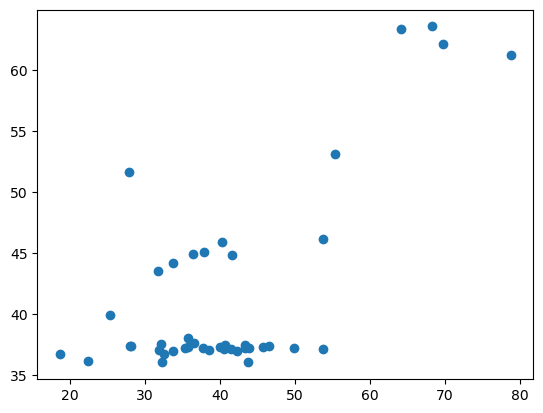

In [619]:
plt.scatter(grid_eval_df['y_Tm'],grid_eval_df['y_Tm_pred'])
string='Tm'
scallers_grids=[scaler_dH,scaler_dS,scaler_dG,
                scaler_Tm]

for string in GSHT_list:
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats(grid_eval_df,string)
    print(f'{string}: ', r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae)
print(f'  : ','r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae') 

In [534]:
def grid_pred(grid_path,grid_trial_number,model,x_fold_test,y_fold_test): 
    y_pred_train_cv = model.predict(x_fold_test)
    y_pred_train_cv_enthalpy = y_pred_train_cv[0].squeeze()
    y_pred_train_cv_entropy = y_pred_train_cv[1].squeeze()
    y_pred_train_cv_free_energy = y_pred_train_cv[2].squeeze()
    y_pred_train_cv_Tm = y_pred_train_cv[3].squeeze()
    
    y_train_resample_output = pd.DataFrame()
    # y_train_resample_output['ID'] = train_idx[fold_test_index]
    # y_train_resample_output['Temp'] = train_resample['Temp']
    
    y_train_resample_output['y_dH'] = y_fold_test[0]
    y_train_resample_output['y_dS'] = y_fold_test[1]
    y_train_resample_output['y_dG'] = y_fold_test[2]
    y_train_resample_output['y_Tm'] = y_fold_test[3]
    
    y_train_resample_output["y_dH_pred"]=y_pred_train_cv_enthalpy
    y_train_resample_output["y_dS_pred"]=y_pred_train_cv_entropy
    y_train_resample_output["y_dG_pred"]=y_pred_train_cv_free_energy
    y_train_resample_output["y_Tm_pred"]=y_pred_train_cv_Tm
    
    y_train_resample_output.to_csv(f'{grid_path}/true_pred_grid_trial_{grid_trial_number}.csv')
    return y_train_resample_output

In [ ]:
y_1, y_2, y_3, y_4, x, X= load_data(file,prop)

# desc_type = ['RF-Score','H-Bonding','Granulated','DNA-Groups','OHEP','LP_dec2','CountDNA','CountDNAp']
# desc_type = ['Granulated','OHEP','LP_dec2']

GSHT_list=['dH','dS','dG','Tm'] #get the order correct
#### WORK
#### MAC sklearn for CNN

###set global variables
# train test split
test_frac = 0.3
home=os.getcwd()
mc_cv=50
n_folds=5
# n_jobs=1
# epochs=200
grid_number=1
# Initialise train test split:
train_test_split = ShuffleSplit(mc_cv, test_size=test_frac, random_state=1)
train_test_split_hp = ShuffleSplit(1, test_size=test_frac, random_state=1)

# Monte Carlo CV:
resample=0
for train_idx, test_idx in train_test_split.split(x):
    resample+=1
    # add a resample skipper
    # print(f'resample: {resample}')
    if resample!=1:
        break

    print(f'RUN resample: {resample}')

    # ### DEFINE MODEL
    model_name = f'{prop}_multi_task_CNN'
    x_train, x_test, y_train, y_test = wrapped_train_test_split(train_idx,test_idx,file,prop)
    
    # fold splits
    kf=KFold(n_splits=n_folds)
    keyList = ['trial',
                 'model_type1',
                 'model_type',
                     'layer_3_3',
                     'layer_2_2',
                     'layer_1',
               'r2_dH_0','rmsd_dH_0','bias_dH_0','SDEP_dH_0','gradient_dH_0','b_dH_0','mse_dH_0','mae_dH_0',
               'r2_dH_1','rmsd_dH_1','bias_dH_1','SDEP_dH_1','gradient_dH_1','b_dH_1','mse_dH_1','mae_dH_1',
               'r2_dH_2','rmsd_dH_2','bias_dH_2','SDEP_dH_2','gradient_dH_2','b_dH_2','mse_dH_2','mae_dH_2',
               'r2_dH_3','rmsd_dH_3','bias_dH_3','SDEP_dH_3','gradient_dH_3','b_dH_3','mse_dH_3','mae_dH_3',
               'r2_dH_4','rmsd_dH_4','bias_dH_4','SDEP_dH_4','gradient_dH_4','b_dH_4','mse_dH_4','mae_dH_4',
               'r2_dH_mean','rmsd_dH_mean','bias_dH_mean','SDEP_dH_mean','gradient_dH_mean','b_dH_mean','mse_dH_mean','mae_dH_mean',
               'r2_dH_std','rmsd_dH_std','bias_dH_std','SDEP_dH_std','gradient_dH_std','b_dH_std','mse_dH_std','mae_dH_std',
               'r2_dS_0','rmsd_dS_0','bias_dS_0','SDEP_dS_0','gradient_dS_0','b_dS_0','mse_dS_0','mae_dS_0',
               'r2_dS_1','rmsd_dS_1','bias_dS_1','SDEP_dS_1','gradient_dS_1','b_dS_1','mse_dS_1','mae_dS_1',
               'r2_dS_2','rmsd_dS_2','bias_dS_2','SDEP_dS_2','gradient_dS_2','b_dS_2','mse_dS_2','mae_dS_2',
               'r2_dS_3','rmsd_dS_3','bias_dS_3','SDEP_dS_3','gradient_dS_3','b_dS_3','mse_dS_3','mae_dS_3',
               'r2_dS_4','rmsd_dS_4','bias_dS_4','SDEP_dS_4','gradient_dS_4','b_dS_4','mse_dS_4','mae_dS_4',
               'r2_dS_mean','rmsd_dS_mean','bias_dS_mean','SDEP_dS_mean','gradient_dS_mean','b_dS_mean','mse_dS_mean','mae_dS_mean',
               'r2_dS_std','rmsd_dS_std','bias_dS_std','SDEP_dS_std','gradient_dS_std','b_dS_std','mse_dS_std','mae_dS_std',
               'r2_dG_0','rmsd_dG_0','bias_dG_0','SDEP_dG_0','gradient_dG_0','b_dG_0','mse_dG_0','mae_dG_0',
               'r2_dG_1','rmsd_dG_1','bias_dG_1','SDEP_dG_1','gradient_dG_1','b_dG_1','mse_dG_1','mae_dG_1',
               'r2_dG_2','rmsd_dG_2','bias_dG_2','SDEP_dG_2','gradient_dG_2','b_dG_2','mse_dG_2','mae_dG_2',
               'r2_dG_3','rmsd_dG_3','bias_dG_3','SDEP_dG_3','gradient_dG_3','b_dG_3','mse_dG_3','mae_dG_3',
               'r2_dG_4','rmsd_dG_4','bias_dG_4','SDEP_dG_4','gradient_dG_4','b_dG_4','mse_dG_4','mae_dG_4',
               'r2_dG_mean','rmsd_dG_mean','bias_dG_mean','SDEP_dG_mean','gradient_dG_mean','b_dG_mean','mse_dG_mean','mae_dG_mean',
               'r2_dG_std','rmsd_dG_std','bias_dG_std','SDEP_dG_std','gradient_dG_std','b_dG_std','mse_dG_std','mae_dG_std',

               'r2_Tm_0','rmsd_Tm_0','bias_Tm_0','SDEP_Tm_0','gradient_Tm_0','b_Tm_0','mse_Tm_0','mae_Tm_0',
               'r2_Tm_1','rmsd_Tm_1','bias_Tm_1','SDEP_Tm_1','gradient_Tm_1','b_Tm_1','mse_Tm_1','mae_Tm_1',
               'r2_Tm_2','rmsd_Tm_2','bias_Tm_2','SDEP_Tm_2','gradient_Tm_2','b_Tm_2','mse_Tm_2','mae_Tm_2',
               'r2_Tm_3','rmsd_Tm_3','bias_Tm_3','SDEP_Tm_3','gradient_Tm_3','b_Tm_3','mse_Tm_3','mae_Tm_3',
               'r2_Tm_4','rmsd_Tm_4','bias_Tm_4','SDEP_Tm_4','gradient_Tm_4','b_Tm_4','mse_Tm_4','mae_Tm_4',
               'r2_Tm_mean','rmsd_Tm_mean','bias_Tm_mean','SDEP_Tm_mean','gradient_Tm_mean','b_Tm_mean','mse_Tm_mean','mae_Tm_mean',
               'r2_Tm_std','rmsd_Tm_std','bias_Tm_std','SDEP_Tm_std','gradient_Tm_std','b_Tm_std','mse_Tm_std','mae_Tm_std',
              ]
    
    n = dict(zip(keyList, [None]*len(keyList)))
    df_grid=pd.DataFrame(n,index=['a'])
    
    for i_fold, (fold_train_index, fold_test_index) in enumerate(kf.split(x_train)):
        # print('fold: ', i_fold)
        print('RUN fold',i_fold)
        # add a fold skipper
        x_fold_train, x_fold_test, y_fold_train, y_fold_test = wrapped_train_val_split(fold_train_index,fold_test_index,pd.DataFrame(x_train),y_train)

        path="{}/CV/{}/{}/{}/{}/fold_{}".format('/users/qdb16186/CNN_multitask_grid',resample,model_name,prop,GSHT,i_fold)
        tuner = kt.GridSearch(build_model,
                                   objective=kt.Objective('val_loss', 'min'),
                                    # loss = 'val_loss',
                                   # objective = ['val_mse','epoch_entropy_pred_mse','val_free_energy_pred_mse'],
                                  directory=f'{path}/hyper_param_tunning_tunner_fold_{i_fold}',
                                  overwrite=False,
                                  project_name=f'{batch}')
        # Find all trial number and cycle through them
        selection=os.listdir(tuner.project_dir)
        for dir_ in selection:
            if "trial_" not in dir_:
                continue
            # trial_number='0036'
            trial_number=str(dir_.replace("trial_",""))
            trial=tuner.oracle.get_trial(trial_number)
            model=tuner.load_model(trial)
            
            y_pred_train_cv = model.predict(x_fold_test)
            y_pred_train_cv_enthalpy = y_pred_train_cv[0].squeeze()
            y_pred_train_cv_entropy = y_pred_train_cv[1].squeeze()
            y_pred_train_cv_free_energy = y_pred_train_cv[2].squeeze()
            y_pred_train_cv_Tm = y_pred_train_cv[3].squeeze()
    
            y_train_resample_output = pd.DataFrame()
            y_train_resample_output['ID'] = train_idx[fold_test_index]
            # y_train_resample_output['Temp'] = train_resample['Temp']
            
            y_train_resample_output['y_dH'] = y_fold_test[0]
            y_train_resample_output['y_dS'] = y_fold_test[1]
            y_train_resample_output['y_dG'] = y_fold_test[2]
            y_train_resample_output['y_Tm'] = y_fold_test[3]
            
            y_train_resample_output["y_dH_pred"]=y_pred_train_cv_enthalpy
            y_train_resample_output["y_dS_pred"]=y_pred_train_cv_entropy
            y_train_resample_output["y_dG_pred"]=y_pred_train_cv_free_energy
            y_train_resample_output["y_Tm_pred"]=y_pred_train_cv_Tm
    
            y_train_resample_output.to_csv(f'{path}/true_pred_fold_{i_fold}_trial_{trial_number}.csv')
            for string in GSHT_list:
                r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats(y_train_resample_output,string)
                if trial_number in df_grid.index:
                    n = df_grid.loc[trial_number].to_dict()
                # else:
                # n = df.loc[trial_number].to_dict() if trial_number in df_grid.index else {}
                n.update({"trial":trial_number,})
                n.update({f'r2_{string}_{i_fold}':r2,f'rmsd_{string}_{i_fold}': rmsd, 
                          f'bias_{string}_{i_fold}': bias, f'SDEP_{string}_{i_fold}': sdep,
                          f'gradient_{string}_{i_fold}': plot_a, f'b_{string}_{i_fold}': plot_b, 
                          f'mse_{string}_{i_fold}':mse, f'mae_{string}_{i_fold}':mae,})
                
                original_stdout = sys.stdout 	
    
                with open('temp.txt', 'w') as f:
                    sys.stdout = f
                    # tunner.results_summary(5)
                    trial.display_hyperparameters()
                    # Reset the standard output
                    sys.stdout = original_stdout 
                f.close
                
                # with open('temp_monitor.txt', 'a+') as f:
                #     sys.stdout = f
                #     # tunner.results_summary(5)
                #     trial.display_hyperparameters()
                #     # Reset the standard output
                #     sys.stdout = original_stdout 
                # f.close
    
                data = open('temp.txt', 'r').read()
                data_hyp_param=data.replace(': ','\n').split('\n')
                i_index=0
                while i_index+1 < len(data_hyp_param):
                    # print(i_index,len(data_hyp_param))
                    n.update({data_hyp_param[i_index]:data_hyp_param[i_index+1]})
                    i_index+=2
                    
                df_grid.loc[f'{trial_number}']=n
        
    break

In [432]:

# n
# df_grid= df_grid.drop('a',axis=0)
df_grid=df_grid.sort_values('trial')
df_temp=pd.DataFrame()
# df_temp['Tm_min']=df_grid[['r2_Tm_0', 'r2_Tm_1', 'r2_Tm_2','r2_Tm_3','r2_Tm_4']].min(axis=1)
# df_temp['Tm_min'].min(axis=1)

df_grid.iloc[:, 5:] = df_grid.iloc[:, 5:].astype(float)
for string in GSHT_list:

    df_temp[f'{string}_mean']=df_grid[[f'r2_{string}_0', f'r2_{string}_1', f'r2_{string}_2',f'r2_{string}_3',f'r2_{string}_4']].mean(axis=1)
    df_temp[f'{string}_std'] =df_grid[[f'r2_{string}_0', f'r2_{string}_1', f'r2_{string}_2',f'r2_{string}_3',f'r2_{string}_4']].std(axis=1)
    # df_temp[f'{string}_mean']=df_grid[[f'rmsd_{string}_0', f'rmsd_{string}_1', f'rmsd_{string}_2',f'rmsd_{string}_3',f'rmsd_{string}_4']].mean(axis=1)
    # df_temp[f'{string}_std'] =df_grid[[f'rmsd_{string}_0', f'rmsd_{string}_1', f'rmsd_{string}_2',f'rmsd_{string}_3',f'rmsd_{string}_4']].std(axis=1)
# df_temp
# df_temp.idxmax()
# df_temp.iloc[138,:]
df_temp
# 
df_grid[['r2_Tm_0', 'r2_Tm_1', 'r2_Tm_2','r2_Tm_3','r2_Tm_4']].max()
# df_temp['Tm_min'].min(axis=1)
df_temp=df_temp.apply(pd.to_numeric)

df_temp['ratio_dH']=(df_temp["dH_mean"]/df_temp["dH_mean"].min())
df_temp['ratio_dG']=(df_temp["dG_mean"]/df_temp["dG_mean"].min())
df_temp['ratio_dS']=(df_temp["dS_mean"]/df_temp["dS_mean"].min())
df_temp['ratio_Tm']=(df_temp["Tm_mean"]/df_temp["Tm_mean"].min())
df_temp['selection']=df_temp['ratio_dH']+df_temp['ratio_dG']+df_temp['ratio_dS']+df_temp['ratio_Tm']

# df_temp['sum_ratio_rmsd_rmsd_best']=((df_temp["dH_mean"]/df_temp["dH_mean"].min()))
df_temp.dtypes
df_temp['selection'].min()
df_temp.index[df_temp['selection'] == df_temp['selection'].min()][0]

'0028'

In [417]:
df_temp['dH_mean'].min()
st_grid=pd.read_csv('/users/qdb16186/CNN_single_task_grid/CV/1/CNN_single_task_Granulated_dH_10/Granulated/dH/gridsearch_resample_1_pipe_cond_No_scalling.csv')
print(st_grid['mean_test_r2'].max())
# st_grid.columns
best_index=st_grid.index[st_grid['mean_test_r2'] == st_grid['mean_test_r2'].max()]
st_grid.loc[best_index[0]]['params']

0.9321285786079102


"{'convn': 2, 'dense1': 16, 'dense2': 16, 'dense3': 8}"

In [281]:
df_grid.to_csv("{}/CV/{}/{}/{}/{}".format('/users/qdb16186/CNN_multitask_grid',resample,model_name,prop,GSHT)+f'/Gridsearch_resample_{resample}.csv')

In [243]:
len(y_fold_test[0])
len(fold_test_index)
# len(y_train_resample_output)
len(x_fold_train)#x_fold_test, y_fold_train, y_fold_test = wrapped_train_val_split(fold_train_index,fold_test_index
len(fold_train_index)
fold_train_index
fold_test_index
x_train
fold_test_index
print(len(x_fold_test),len(y_fold_test),len(x_fold_test))
print(len(x_fold_train),len(y_fold_train),len(x_fold_train))
print(len(train_idx),len(test_idx))

print( len(x_train), len(x_test), len(y_train), len(y_test))
print(len(fold_train_index), len(fold_test_index))
print(len(x_fold_train), len(x_fold_test), len(y_fold_train[0]), len(y_fold_test[0]))
train_idx[fold_test_index]

43 4 43
170 4 170
213 92
213 92 4 4
170 43
170 43 170 43


array([135, 103, 260, 223, 226, 190, 270,  92, 297, 205, 261, 290, 273,
       301, 126, 280,  80, 148,  63, 219,  54, 274,   3, 218,   9, 209,
        43, 201, 197,  51, 215, 241, 245, 288, 242, 200, 208, 165,  40,
         5, 172, 222,  38])

In [459]:
def stats(df2,string):
    y_test = df2[f'y_{string}']
    y_pred_test = df2[f'y_{string}_pred']
    y_test_np = y_test.to_numpy()
    y_pred_test_np = y_pred_test.to_numpy()
    r2_test = r2_score(y_test_np, y_pred_test_np)
    rmsd_test = (mean_squared_error(y_test_np, y_pred_test_np))**0.5
    bias_test = np.mean(y_pred_test_np - y_test_np)
    sdep_test = (np.mean((y_pred_test_np - y_test_np - bias_test)**2))**0.5
    r2 = '{:.3f}'.format(r2_test)
    rmsd = '{:.3f}'.format(rmsd_test)
    bias = '{:.3f}'.format(bias_test)
    sdep = '{:.3f}'.format(sdep_test)
    
    
    mse=mean_squared_error(y_test_np, y_pred_test_np)
    mse='{:.3f}'.format(mse)
    mae=mean_absolute_error(y_test_np, y_pred_test_np)
    mae='{:.3f}'.format(mae)
    try:
        a, b = np.polyfit(df2[f'y_{string}'], df2[f'y_{string}_pred'], 1)
        plot_a = '{:.3f}'.format(a)
        plot_b = '{:.3f}'.format(b)
    except np.linalg.LinAlgError:
        pass
    
    return r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae

In [245]:
y_train_resample_output
# x_fold_test
# fold_test_index
# fold_test_index

,ID,y_dH,y_dS,y_dG,y_Tm,y_dH_pred,y_dS_pred,y_dG_pred,y_Tm_pred
0,188,-60.7,-167.0,-8.8,42.0,-61.500645,-169.027771,-8.984352,37.476528
1,290,-50.5,-137.0,-8.2,40.0,-60.055622,-165.068069,-8.752142,36.608147
2,192,-59.2,-160.0,-9.5,45.8,-62.001411,-170.477493,-9.067005,37.777699
3,224,-61.2,-175.0,-6.9,31.9,-60.062950,-164.951431,-8.784157,36.585480
4,284,-58.8,-164.0,-7.8,36.9,-61.623791,-169.437164,-9.003925,37.559486
5,267,-62.6,-175.0,-8.3,38.9,-60.805748,-167.027512,-8.888939,37.046700
6,19,-62.8,-174.0,-8.8,41.4,-62.632305,-172.098099,-9.159590,38.164021
7,14,-104.4,-281.0,-17.3,67.3,-116.605957,-321.178894,-16.950855,71.466354
8,91,-38.6,-106.0,-5.7,20.1,-44.779964,-122.986465,-6.475912,27.279692
9,208,-59.3,-161.0,-9.5,44.6,-63.594009,-174.698700,-9.309534,38.759052


In [171]:
y_fold_test

[array([ -60.7,  -50.5,  -59.2,  -61.2,  -58.8,  -62.6,  -62.8, -104.4,
         -38.6,  -59.3,  -67.3,  -53.1,  -56.3, -119.6,  -57.6,  -54.7,
         -48.7, -122.9,  -51.7,  -62.8,  -66.2,  -76.7,  -54.5,  -62.1,
        -128. ,  -56.9,  -59. ,  -58.1,  -60.4,  -44.2,  -61.6,  -69.1,
         -60.7,  -57.5,  -60. ,  -57.5,  -76.3,  -56.8,  -54.6,  -59.3,
         -59.6,  -66.2,  -61. ]),
 array([-167., -137., -160., -175., -164., -175., -174., -281., -106.,
        -161., -188., -145., -155., -325., -160., -149., -135., -336.,
        -145., -172., -183., -216., -157., -170., -352., -161., -161.,
        -156., -163., -123., -170., -195., -171., -161., -163., -162.,
        -220., -154., -152., -167., -161., -186., -170.]),
 array([ -8.8,  -8.2,  -9.5,  -6.9,  -7.8,  -8.3,  -8.8, -17.3,  -5.7,
         -9.5,  -9. ,  -8.3,  -8.3, -18.7,  -7.9,  -8.6,  -6.8, -18.7,
         -6.6,  -9.5,  -9.3,  -9.7,  -5.9,  -9.4, -18.9,  -6.9,  -9. ,
         -9.7,  -9.8,  -6.1,  -8.8,  -8.7,  -7.7, 

In [107]:
import matplotlib.pyplot as plt

model_type1: CNN3
model_type: Dense3
layer_1: 128
layer_2_2: 32
layer_3_3: 16
2/2 [==============================] - 0s 3ms/step


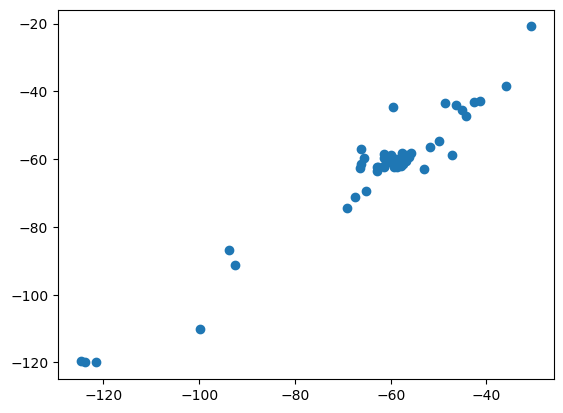

In [133]:
# tuner.load_model(trial="trail_0030")
# tuner.search_space_summary()
# tuner.get_best_models()
# tuner.get_best_hyperparameters()
# tuner.results_summary()
# trial=tuner.oracle.get_trial("0039")
# # tuner.get_best_models()[0].predict(pd.read_csv(f'{path}/Split_x_1_type_train_hp_fold_0_pipe_cond_No_scalling.csv'))
# # tuner.oracle.get_trial("0039").predict(pd.read_csv(f'{path}/Split_x_1_type_train_hp_fold_0_pipe_cond_No_scalling.csv'))
# # tuner
# print(trial.trial_id)
# print(trial.best_step)
# trial.display_hyperparameters()
# print(trial.score)
# trial.summary()
# # print(trial.trial_id)
# # trial.save('test.csv')
# trial
# current_model2=tuner.load_model(trial)
# y_pred=current_model2.predict(pd.read_csv(f'{path}/Split_x_1_type_train_hp_fold_0_pipe_cond_No_scalling.csv'))
# y_true=pd.read_csv(f'{path}/Split_y_1_type_train_hp_fold_0_pipe_cond_No_scalling.csv')
# y_true
# # y_pred


trial=tuner.oracle.get_trial("0039")
trial.display_hyperparameters()

X_train_cv=pd.read_csv(f'{path}/Split_x_1_type_val_hp_fold_0_pipe_cond_No_scalling.csv')
train_resample=pd.read_csv(f'{path}/Split_y_1_type_val_hp_fold_0_pipe_cond_No_scalling.csv')

model=tuner.load_model(trial)
# model.expect_partial()
# save_model_predictions_trial(current_model2,X_train_cv,X_train_true,'triela_0039',"train")

y_pred_train_cv = model.predict(X_train_cv)
y_pred_train_cv_enthalpy = y_pred_train_cv[0].squeeze()
y_pred_train_cv_entropy = y_pred_train_cv[1].squeeze()
y_pred_train_cv_free_energy = y_pred_train_cv[2].squeeze()
y_pred_train_cv_Tm = y_pred_train_cv[3].squeeze()

y_train_resample_output = pd.DataFrame()
y_train_resample_output['DNA'] = train_resample.iloc[:, 0]
# y_train_resample_output['Temp'] = train_resample['Temp']

y_train_resample_output['y_dH'] = train_resample.iloc[:, 1]
y_train_resample_output['y_dS'] = train_resample.iloc[:, 2]
y_train_resample_output['y_dG'] = train_resample.iloc[:, 3]
y_train_resample_output['y_Tm'] = train_resample.iloc[:, 4]

y_train_resample_output["y_dH_pred"]=y_pred_train_cv_enthalpy
y_train_resample_output["y_dS_pred"]=y_pred_train_cv_entropy
y_train_resample_output["y_dG_pred"]=y_pred_train_cv_free_energy
y_train_resample_output["y_Tm_pred"]=y_pred_train_cv_Tm
y_train_resample_output
plt.scatter(y_train_resample_output['y_dH'],y_train_resample_output['y_dH_pred'])

In [ ]:
def stats(trial_number,set_type):
    test=os.getcwd()+f'/trial_predictions/trial_predictions_{trial_number}_{set_type}plot.csv'
    df=pd.read_csv(test)
    df2=df
    y_test = df2[f'y_{string}']
    y_pred_test = df2[f'y_{string}_pred']
    y_test_np = y_test.to_numpy()
    y_pred_test_np = y_pred_test.to_numpy()
    r2_test = r2_score(y_test_np, y_pred_test_np)
    rmsd_test = (mean_squared_error(y_test_np, y_pred_test_np))**0.5
    bias_test = np.mean(y_pred_test_np - y_test_np)
    sdep_test = (np.mean((y_pred_test_np - y_test_np - bias_test)**2))**0.5
    r2 = '{:.3f}'.format(r2_test)
    rmsd = '{:.3f}'.format(rmsd_test)
    bias = '{:.3f}'.format(bias_test)
    sdep = '{:.3f}'.format(sdep_test)
    
    
    mse=mean_squared_error(y_test_np, y_pred_test_np)
    mse='{:.3f}'.format(mse)
    mae=mean_absolute_error(y_test_np, y_pred_test_np)
    mae='{:.3f}'.format(mae)
    try:
        a, b = np.polyfit(df2[f'y_{string}'], df2[f'y_{string}_pred'], 1)
        plot_a = '{:.3f}'.format(a)
        plot_b = '{:.3f}'.format(b)
    except np.linalg.LinAlgError:
        pass
    
    return r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae

In [102]:
n = dict(zip(keyList, [None]*len(keyList)))
df=pd.DataFrame(n,index=['a'])
string_options=['entropy']
set_type='test'
for string in string_options:
    for dir_ in selection:
        if "trial_" in dir_:
            trial_number=str(dir_.replace("trial_",""))
            trial=tunner.oracle.get_trial(trial_number)
            # current_model2=tuner.load_model(trial)
            
            
            # plot(trial_number,set_type)
            r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats(trial_number,set_type)
            n = dict(zip(keyList, [None]*len(keyList)))
            n.update({"trial":trial_number,"property": string,'set_type': set_type,})
            n.update({'r2':r2,'rmsd': rmsd, 'bias': bias, 'SDEP': sdep,'gradient': plot_a, 'b': plot_b, 'mse':mse, 'mae':mae,})
            
            original_stdout = sys.stdout 	

            with open('temp.txt', 'w') as f:
                sys.stdout = f
                # tunner.results_summary(5)
                trial.display_hyperparameters()
                # Reset the standard output
                sys.stdout = original_stdout 
            f.close
            
            # with open('temp_monitor.txt', 'a+') as f:
            #     sys.stdout = f
            #     # tunner.results_summary(5)
            #     trial.display_hyperparameters()
            #     # Reset the standard output
            #     sys.stdout = original_stdout 
            # f.close

            data = open('temp.txt', 'r').read()
            data_hyp_param=data.replace(': ','\n').split('\n')
            i_index=0
            while i_index+1 < len(data_hyp_param):
                # print(i_index,len(data_hyp_param))
                n.update({data_hyp_param[i_index]:data_hyp_param[i_index+1]})
                i_index+=2
                
            df.loc[f'{trial_number}']=n
df

0      -60.0
1      -56.3
2      -56.8
3      -53.6
4      -60.4
       ...  
114    -40.4
115    -71.3
116   -125.6
117    -49.2
118    -56.8
Name: y_true_0, Length: 119, dtype: float64

In [60]:
pd.read_csv(f'{path}/Split_x_1_type_train_hp_fold_0_pipe_cond_No_scalling.csv')

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,173.0,83.0,205.0,72.0,149.0,426.0,129.0,533.0,378.0,216.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,173.0,52.0,207.0,87.0,135.0,414.0,136.0,528.0,378.0,216.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,173.0,131.0,150.0,42.0,236.0,413.0,40.0,544.0,387.0,221.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,174.0,101.0,170.0,62.0,200.0,401.0,58.0,538.0,382.0,218.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,174.0,90.0,194.0,73.0,163.0,402.0,85.0,534.0,380.0,218.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,119.0,84.0,116.0,36.0,144.0,282.0,40.0,392.0,278.0,161.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
115,227.0,42.0,226.0,102.0,237.0,560.0,185.0,708.0,505.0,291.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116,391.0,237.0,372.0,134.0,463.0,911.0,126.0,1172.0,845.0,476.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117,173.0,86.0,155.0,56.0,212.0,421.0,87.0,547.0,392.0,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
path+'/Split_x_1_type_train_hp_fold_0_pipe_cond_No_scalling.csv'

'/users/qdb16186/CNN_multitask_grid/CV/0/Granulated_multi_task_CNN/Granulated/dH_dS_dG_Tm/fold_0'

In [95]:
def save_model_predictions_trial(model,X_train_cv,train_resample,trial,set_type):
    
    # Make predictions on train, val and test set using trained model:
    y_pred_train_cv = model.predict(X_train_cv)
    y_pred_train_cv_enthalpy = y_pred_train_cv[0].squeeze()
    y_pred_train_cv_entropy = y_pred_train_cv[1].squeeze()
    y_pred_train_cv_free_energy = y_pred_train_cv[2].squeeze()
    y_pred_train_cv_Tm = y_pred_train_cv[3].squeeze()

    y_train_resample_output = pd.DataFrame()
    y_train_resample_output['DNA'] = train_resample.iloc[:, 0]
    # y_train_resample_output['Temp'] = train_resample['Temp']
    
    y_train_resample_output['y_dH'] = train_resample[:, 1]
    y_train_resample_output['y_dS'] = train_resample[:, 2]
    y_train_resample_output['y_dG'] = train_resample[:, 3]
    y_train_resample_output['y_Tm'] = train_resample[:, 4]
    
    y_train_resample_output["y_dH_pred"]=y_pred_train_cv_enthalpy
    y_train_resample_output["y_dS_pred"]=y_pred_train_cv_entropy
    y_train_resample_output["y_dG_pred"]=y_pred_train_cv_free_energy
    y_train_resample_output["y_Tm_pred"]=y_pred_train_cv_Tm
    
    return y_train_resample_output
    # y_train_resample_output.to_csv(f'trial_predictions/trial_predictions_{trial}_{set_type}plot.csv', index=False)


In [ ]:
cur_dir
selection=os.listdir("/users/qdb16186/ml_evaluation/dir/grid6/")

for dir_ in selection:
    if "trial_" in dir_:
        trial=tunner.oracle.get_trial(str(dir_.replace("trial_","")))
        try:
            current_model2=tunner.load_model(trial)
            save_model_predictions_trial(current_model2,X_train_cv,train,str(dir_.replace("trial_","")),"train")
            save_model_predictions_trial(current_model2,X_val_cv,val,str(dir_.replace("trial_","")),"val")
            save_model_predictions_trial(current_model2,X_test_cv,test,str(dir_.replace("trial_","")),"test")
        except:
            pass